# import module

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import optuna

# load data

In [2]:
filepath = 'data/train.csv'
df = pd.read_csv(filepath)

# EDA (Exploratory Data Analysis)

> Exploratory Data Analysis (EDA) 是指一種資料分析的方法。透過對資料的探索性分析來瞭解資料的特徵和結構，並且探索資料中可能存在的關聯性和趨勢。
>
> EDA通常包括以下幾個步驟：<br>
> * 敘述性統計：計算資料的**中心趨勢、變異數、分位數、偏度、峰度**等數值統計量。<br>
> * 資料可視化：使用各種圖表和視覺化工具，如**直方圖、散點圖、箱形圖**等，來展現資料的分佈和變化情況，以及變數之間的關係。<br>
> * 探索性資料分析：使用**機器學習和統計方法**，對資料進行探索性分析，比如找出可能的特徵、確定相關性和假設檢測等。<br>
>
> *-Generated by AI*

以下是我整理出可以用於EDA的方法：

* 觀察數據欄位、屬性
* 觀察單變量的數據分布
    * 數值型資料：histplot, boxplot
    * 類別型資料：barplot
* 觀察多變量之間的數據分布
    * 數值型資料&數值型資料：scatterplot, displot(密度分布)
    * 數值型資料&類別型資料：單變量的分布用類別資料區分
* 檢查是否有缺失值
* 檢查是否有離群值(outlier)
* 使用統計檢定法觀察變數之間的相關性
    * 皮爾森係數：檢查feature之間的線性相關程度；檢查feature跟target之間的線性相關程度
    * 卡方檢驗：用於檢驗binary category features之間的相關程度
* 使用群集分析(clustering)觀察變數之間的相關性
    * hierarchy clustering

### 任務描述
> 在這個競賽中，你需要從製圖變量（而不是遙測數據）中預測森林覆蓋類型（主要的樹木覆蓋種類）。森林覆蓋類型是根據美國林務局第2區資源訊息系統數據來分類的。一些獨立變數是從美國地質調查和美國林務局獲得的數據中衍生出來的。其中包含二元變數，用於定性獨立變數，例如荒野區域和土壤類型。
>
> 這個研究區域包括位於科羅拉多州北部的羅斯福國家森林中的四個荒野區域。這些區域代表著人為干擾最少的森林，因此現有的森林覆蓋類型更多地是由生態過程形成，而不是人為管理形成的。
>> *--Translated by AI*

### 觀察數據欄位、屬性
1. 數據的基本資料
* Id一定是redundant的feature
* numerical feature：海拔(`Elevation`)，方位角(`Aspect`)，斜度(`slope`)，水文距離(`Hydrology`)，山影(`Hillshade`)，火災事發地點距離(`Firpoint`)
* caategorical feature：區域種類(`Wildness_area`)，土地種類(`Soil_type`)
* target：樹種(`Cover_Type`)，1~7
* 沒有任何缺失值
2. 數據的觀察&推測
* 某些泥土(`Soil_Type`)一定會跟某些樹種(`Cover_Type`)很有關係，但是應該不是全部40種。
* 一種樹(`Cover_Type`)可能會對應到不只一種泥土(`Soil_Type`)，所以有相當多的泥土種類(columns about soil type)不是透過one-hot encoding得到的結果。
* 區域種類(`Wildness_area`)可能會跟某些泥土種類(`Soil_type`)有相關性
* 海拔(`Elevation`)，方位角(`Aspect`)，斜度(`slope`)決定了一個地點的絕對位置，可能會跟樹種(`Cover_Type`)有關係

In [3]:
df.shape

(15120, 56)

In [4]:
df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [5]:
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [7]:
df.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [8]:
def stat(df):
    type_list = df.dtypes
    df_stat = pd.DataFrame(type_list,columns=["data types"])
    df_stat['Missing'] = df.isnull().sum()
    df_stat['unique'] = df.nunique()
    return df_stat
df_stat = stat(df).style.background_gradient(cmap='rainbow')
df_stat

,data types,Missing,unique
Id,int64,0,15120
Elevation,int64,0,1665
Aspect,int64,0,361
Slope,int64,0,52
Horizontal_Distance_To_Hydrology,int64,0,400
Vertical_Distance_To_Hydrology,int64,0,423
Horizontal_Distance_To_Roadways,int64,0,3250
Hillshade_9am,int64,0,176
Hillshade_Noon,int64,0,141
Hillshade_3pm,int64,0,247


int64    56
dtype: int64

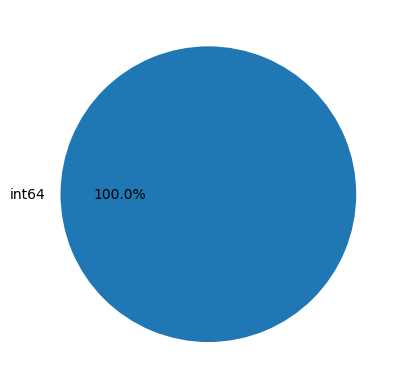

In [9]:
df.dtypes.value_counts().plot(kind="pie",autopct='%.1f%%')
df.dtypes.value_counts()

透過底下的程式觀察得知`Soil_Type7`, `Soil_Type15`是zero columns，可以捨去

In [150]:
soil_cols = []
for i in range(1, 41):
    soil_cols.append('Soil_Type'+str(i))
df_Soil = df[soil_cols]

print('zero columns: ')
for col in soil_cols:
    if col == 'Cover_Type': continue
    if (df_Soil[col] == 0).all():
        print(col)
# we can discard Soil_Type7, Soil_Type15

zero columns: 
Soil_Type7
Soil_Type15


透過皮爾森係數得知以下的feature之間有很高的線性相關程度，雖然其他feature之間的線性相關程度並沒有很高，但是這不代表我們剛剛的推測是無效的。有時候一些feature之間的關係是非線性的，所以我們還需要用其他方法進一步分析。

In [158]:
corr = df.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis=1).corr()
corr.style.background_gradient(cmap='rainbow')

print('The feature pairs which pearson correlation > 0.5: ')
for i in corr.columns:
    for j in corr.columns:
        if i == j: break
        if corr.loc[i,j] > 0.5:
            print('({}, {})'.format(i, j))

The feature pairs which pearson correlation > 0.5: 
(Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Hydrology)
(Horizontal_Distance_To_Roadways, Elevation)
(Hillshade_3pm, Aspect)
(Hillshade_3pm, Hillshade_Noon)
(Soil_Type29, Wilderness_Area1)


### Clustering - Hierarchical clustering

> 層次聚類（Hierarchical clustering）是一種無監督的機器學習技術，用於將相似的數據點分組成不同的簇(clusters)。它通常用於探索性數據分析
(EDA)和分類問題的預處理。
>
> 層次聚類有兩種不同的方法：凝聚型聚類（Agglomerative clustering）和分裂型聚類（Divisive clustering）。在凝聚型聚類中，每個數據點開始被認為是一個單獨的簇，然後通過將最相似的簇合併成新的簇，逐步構建出更大的簇。在分裂型聚類中，所有數據點開始被視為一個大的簇，然後通過將最不相似的數據點分離成新的簇，逐步構建出更小的簇。
>
> 在凝聚型聚類中，聚類過程可以表示為一個樹狀圖（dendrogram）。樹狀圖由底部的個別數據點開始，然後通過逐步合併相似的簇，最終形成一個包含所有數據點的根節點。樹狀圖可以用來可視化聚類過程，並幫助識別數據點之間的相似性。
>
> 層次聚類的性能受到距離度量方法和聚類方法的影響。距離度量方法用於計算數據點之間的距離，常用的距離度量方法包括歐幾里得距離、曼哈頓距離和相關係數等。聚類方法則決定了如何將簇合併或分割，常用的聚類方法包括完全聚合法（Complete-linkage clustering）、平均聚合法（Average-linkage clustering）和簇內平方和聚合法（Ward's method）等。
>> *Generated by AI*

以下將透過Clustering的方法觀察數據之間的相關性

1. 觀察**所有數據**分類結果的樹狀圖，用於觀察最有相關性的feature
2. 觀察泥土(`Soil_Type`)種類和區域(`Wildness_area`)種類的樹狀圖
3. 觀察剩餘的feature之間的相關性

透過1, 2, 3的步驟，我們將得到一些相關性較高的features，將用於feature creation

In [159]:
from scipy import stats
from scipy.cluster import hierarchy as hc
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


##### plot hierarchy clustering tree for all features

以下是可能相關性較高的feature組合：

* 方位角(`Aspect`)和山影(`Hillshade_3pm`, `Hillshade_3Noom`)有關係
* 海拔(`Elevation`)和距離道路遠近(`Horizontal_Distance_to_Roadways`)，火災事故發生地點距離(`Horizontal_Distance_to_Fire_Points`)有關係
* 水平水文距離(`Horizontal_Distance_to_Hydrology`)、垂直水文距離(`Vertical_Distance_to_Hydrology`)有關係
* 區域種類(`Wilderness`)跟泥土種類(`Soil_Type`)有關係

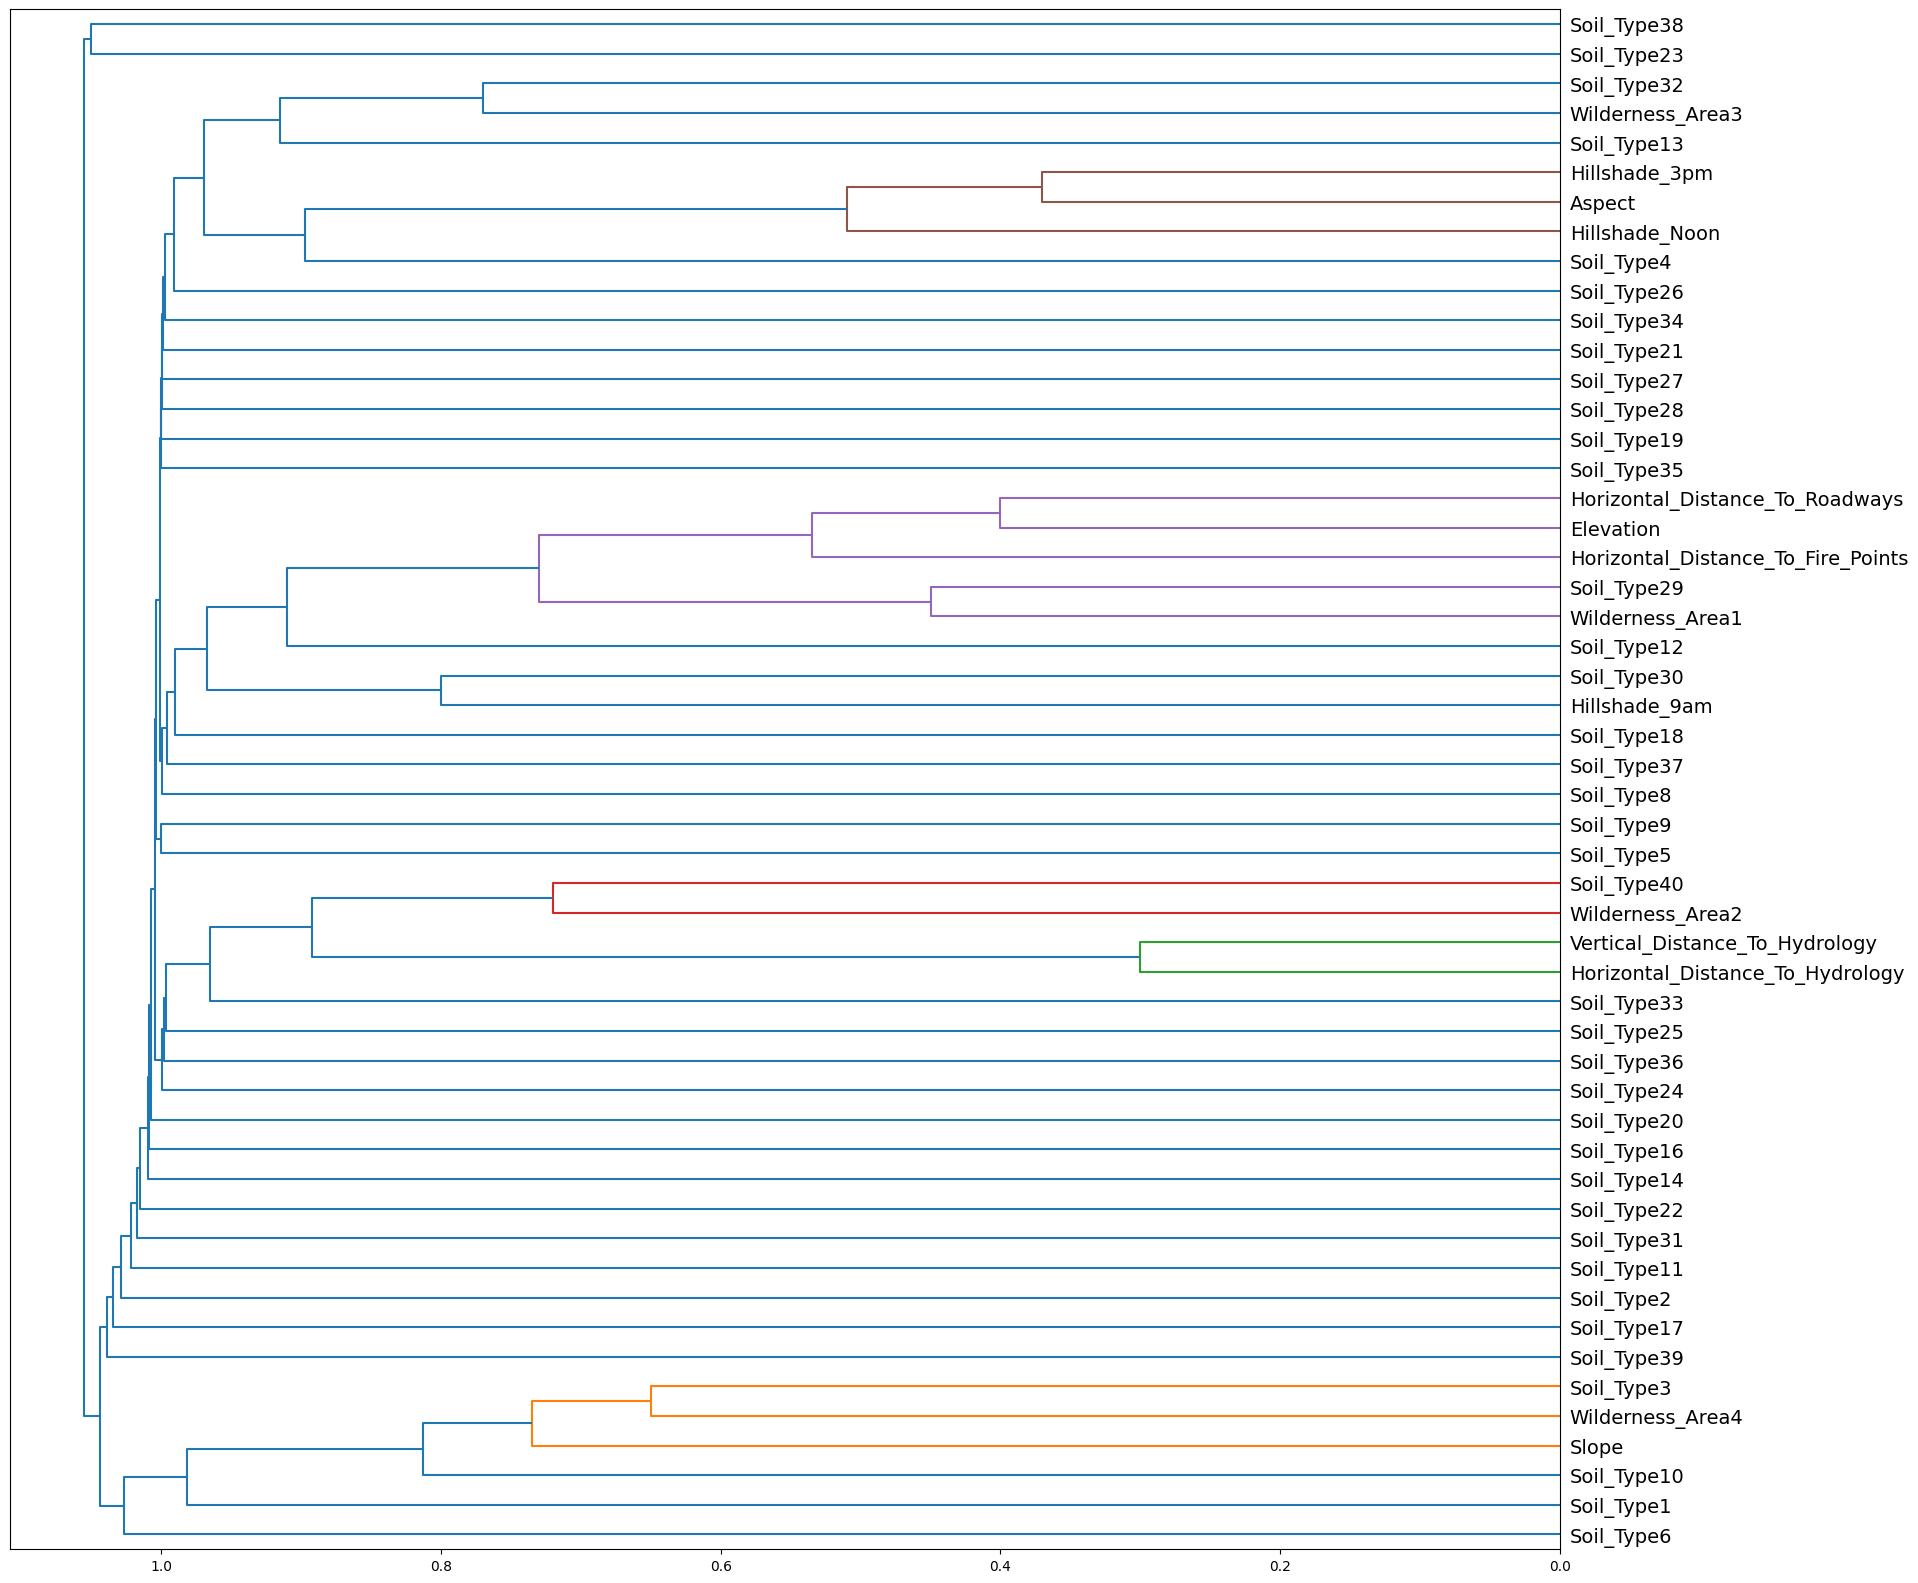

In [160]:
df_copy = df.drop(['Soil_Type7', 'Soil_Type15', 'Id', 'Cover_Type'], axis=1)
corr = np.round(stats.spearmanr(df_copy).correlation, 2)
pd.DataFrame(corr)
plt.figure(figsize=(20,20))
hc.dendrogram(hc.linkage(hc.distance.squareform(1-corr), 
                         method='weighted'), 
              labels=df_copy.columns, orientation='left', 
              leaf_font_size=14)
plt.show()

##### plot hierarchy clustering tree for only wilderness & soil type

以下是不同種類的泥土與相關性最高的區域：

* `Wilderness1`：`Soil_Type29`
* `Wilderness2`：`Soil_Type40`
* `Wilderness3`：`Soil_Type32` (相關性較其他三種組合低，所以顏色一樣是藍色)
* `Wilderness4`：`Soil_Type3`

C:\Users\User\AppData\Local\Temp\ipykernel_11252\4206308572.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wild_soil.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)


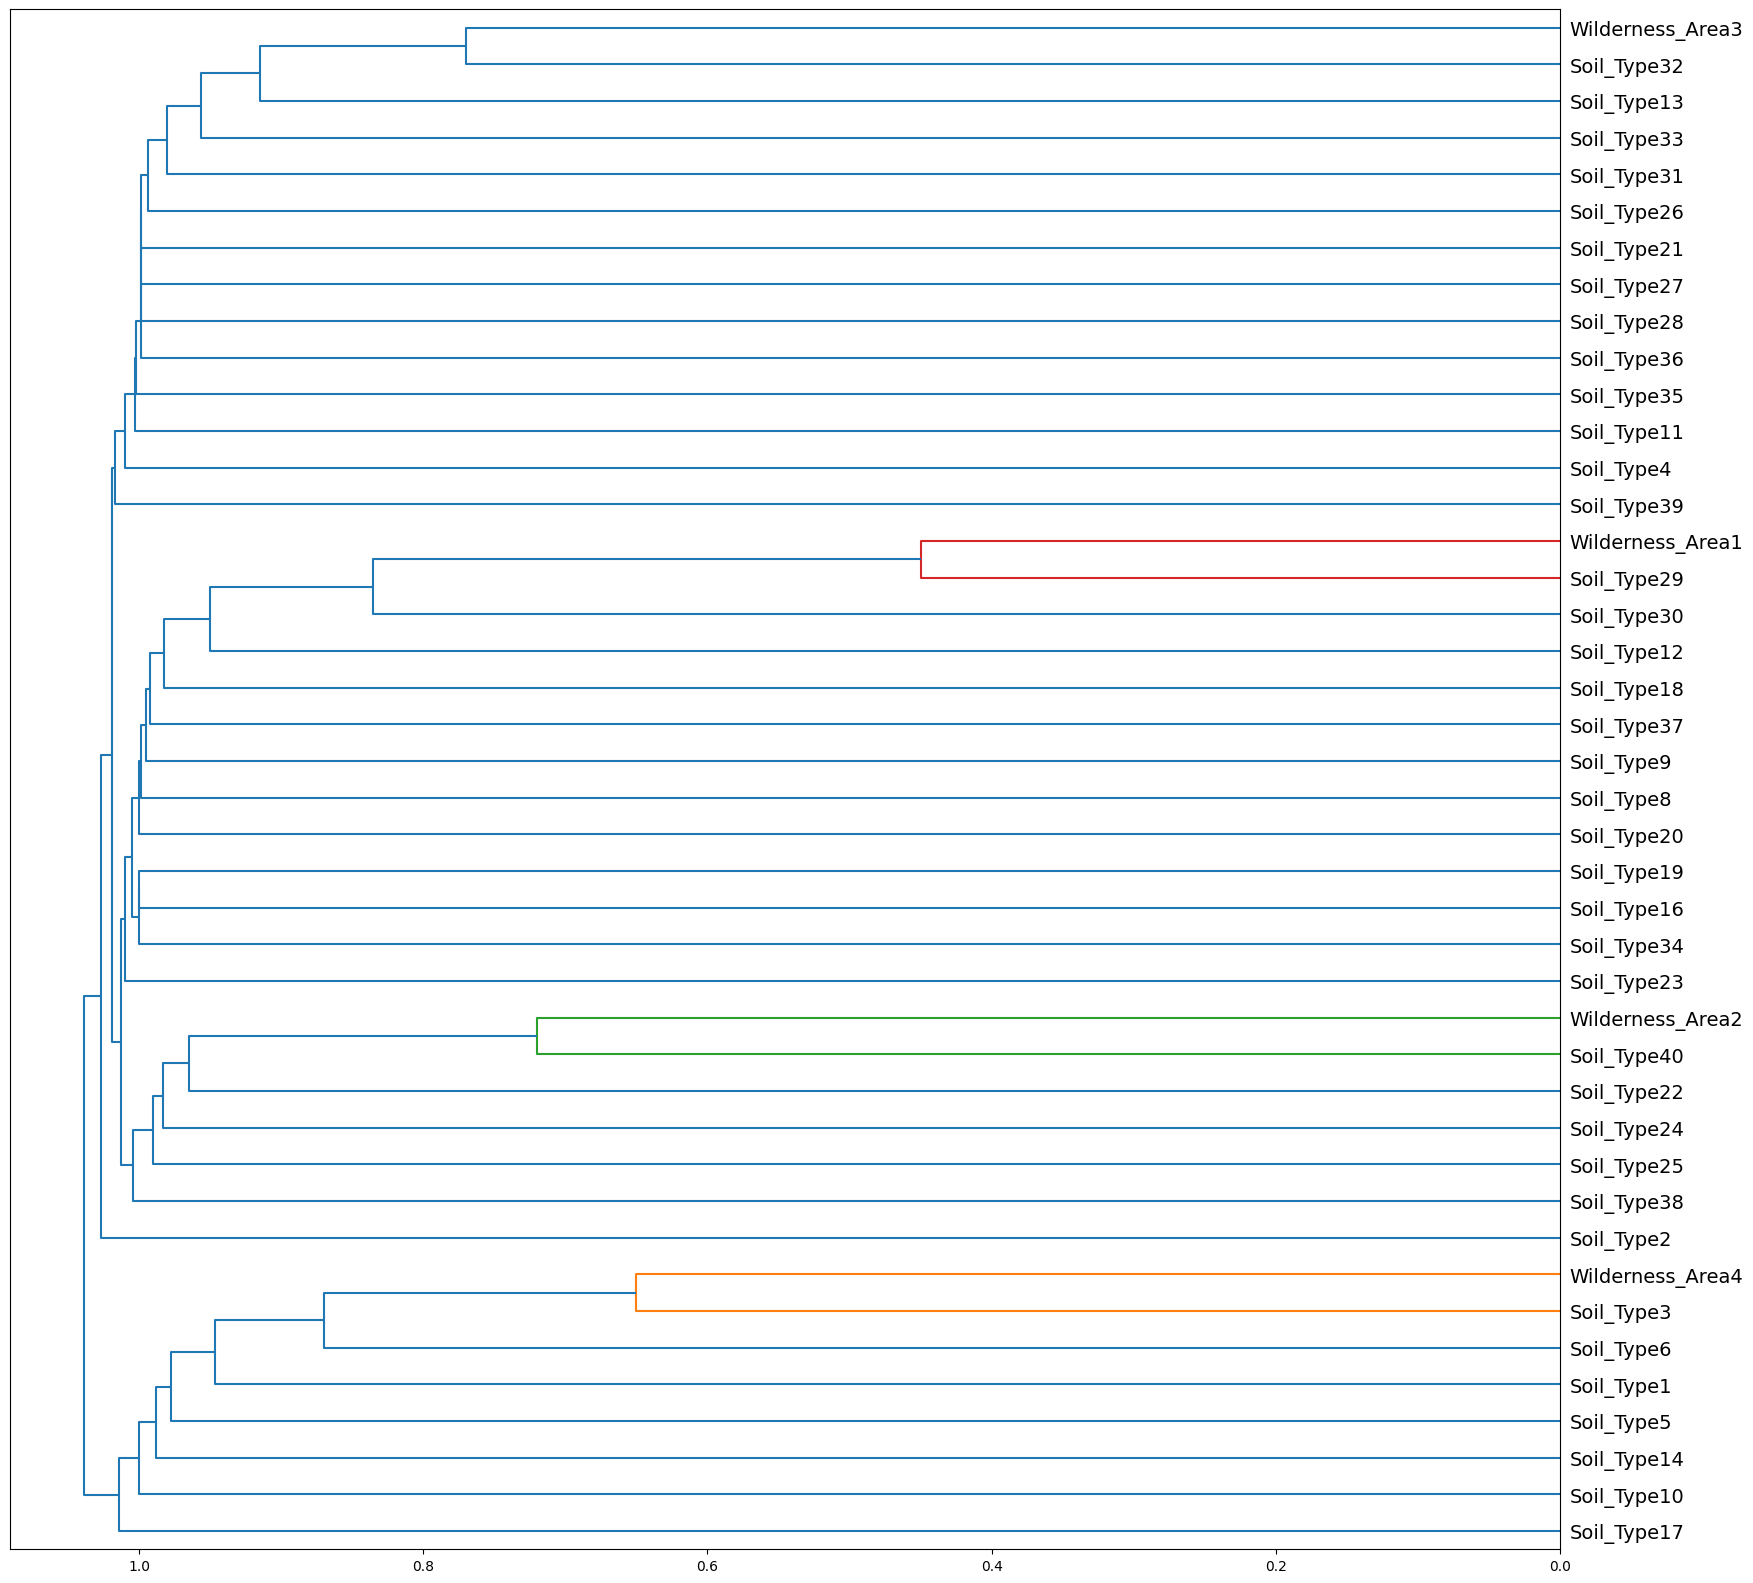

In [156]:
from scipy import stats
from scipy.cluster import hierarchy as hc
soil_cols = []
wild_cols = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
for col in df.columns:
    if col[:4] == 'Soil':
        soil_cols.append(col)
for col in wild_cols:
    soil_cols.append(col)
df_wild_soil = df[soil_cols]
df_wild_soil.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)

corr = np.round(stats.spearmanr(df_wild_soil).correlation, 2)
plt.figure(figsize=(20,20))
hc.dendrogram(hc.linkage(hc.distance.squareform(1-corr), 
                         method='average'), 
              labels=df_wild_soil.columns, orientation='left', 
              leaf_font_size=14)
plt.show()

##### plot hierarchy clustering tree except for wilderness and soil type

* 水平水文距離(`Horizontal_Distance_to_Hydrology`)、垂直水文距離(`Vertical_Distance_to_Hydrology`)有關係
* 海拔(`Elevation`)和距離道路遠近(`Horizontal_Distance_to_Roadways`)，火災事故發生地點距離(`Horizontal_Distance_to_Fire_Points`)有關係
* 方位角(`Aspect`)和山影(`Hillshade_3pm, Hillshade_3Noom`)有關係
* 斜角(`Slope`)可能會跟水文距離有關係，但是相對於其他組合可能性較低

C:\Users\User\AppData\Local\Temp\ipykernel_11252\2392320189.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.drop(['Id', 'Cover_Type'], axis=1, inplace=True)


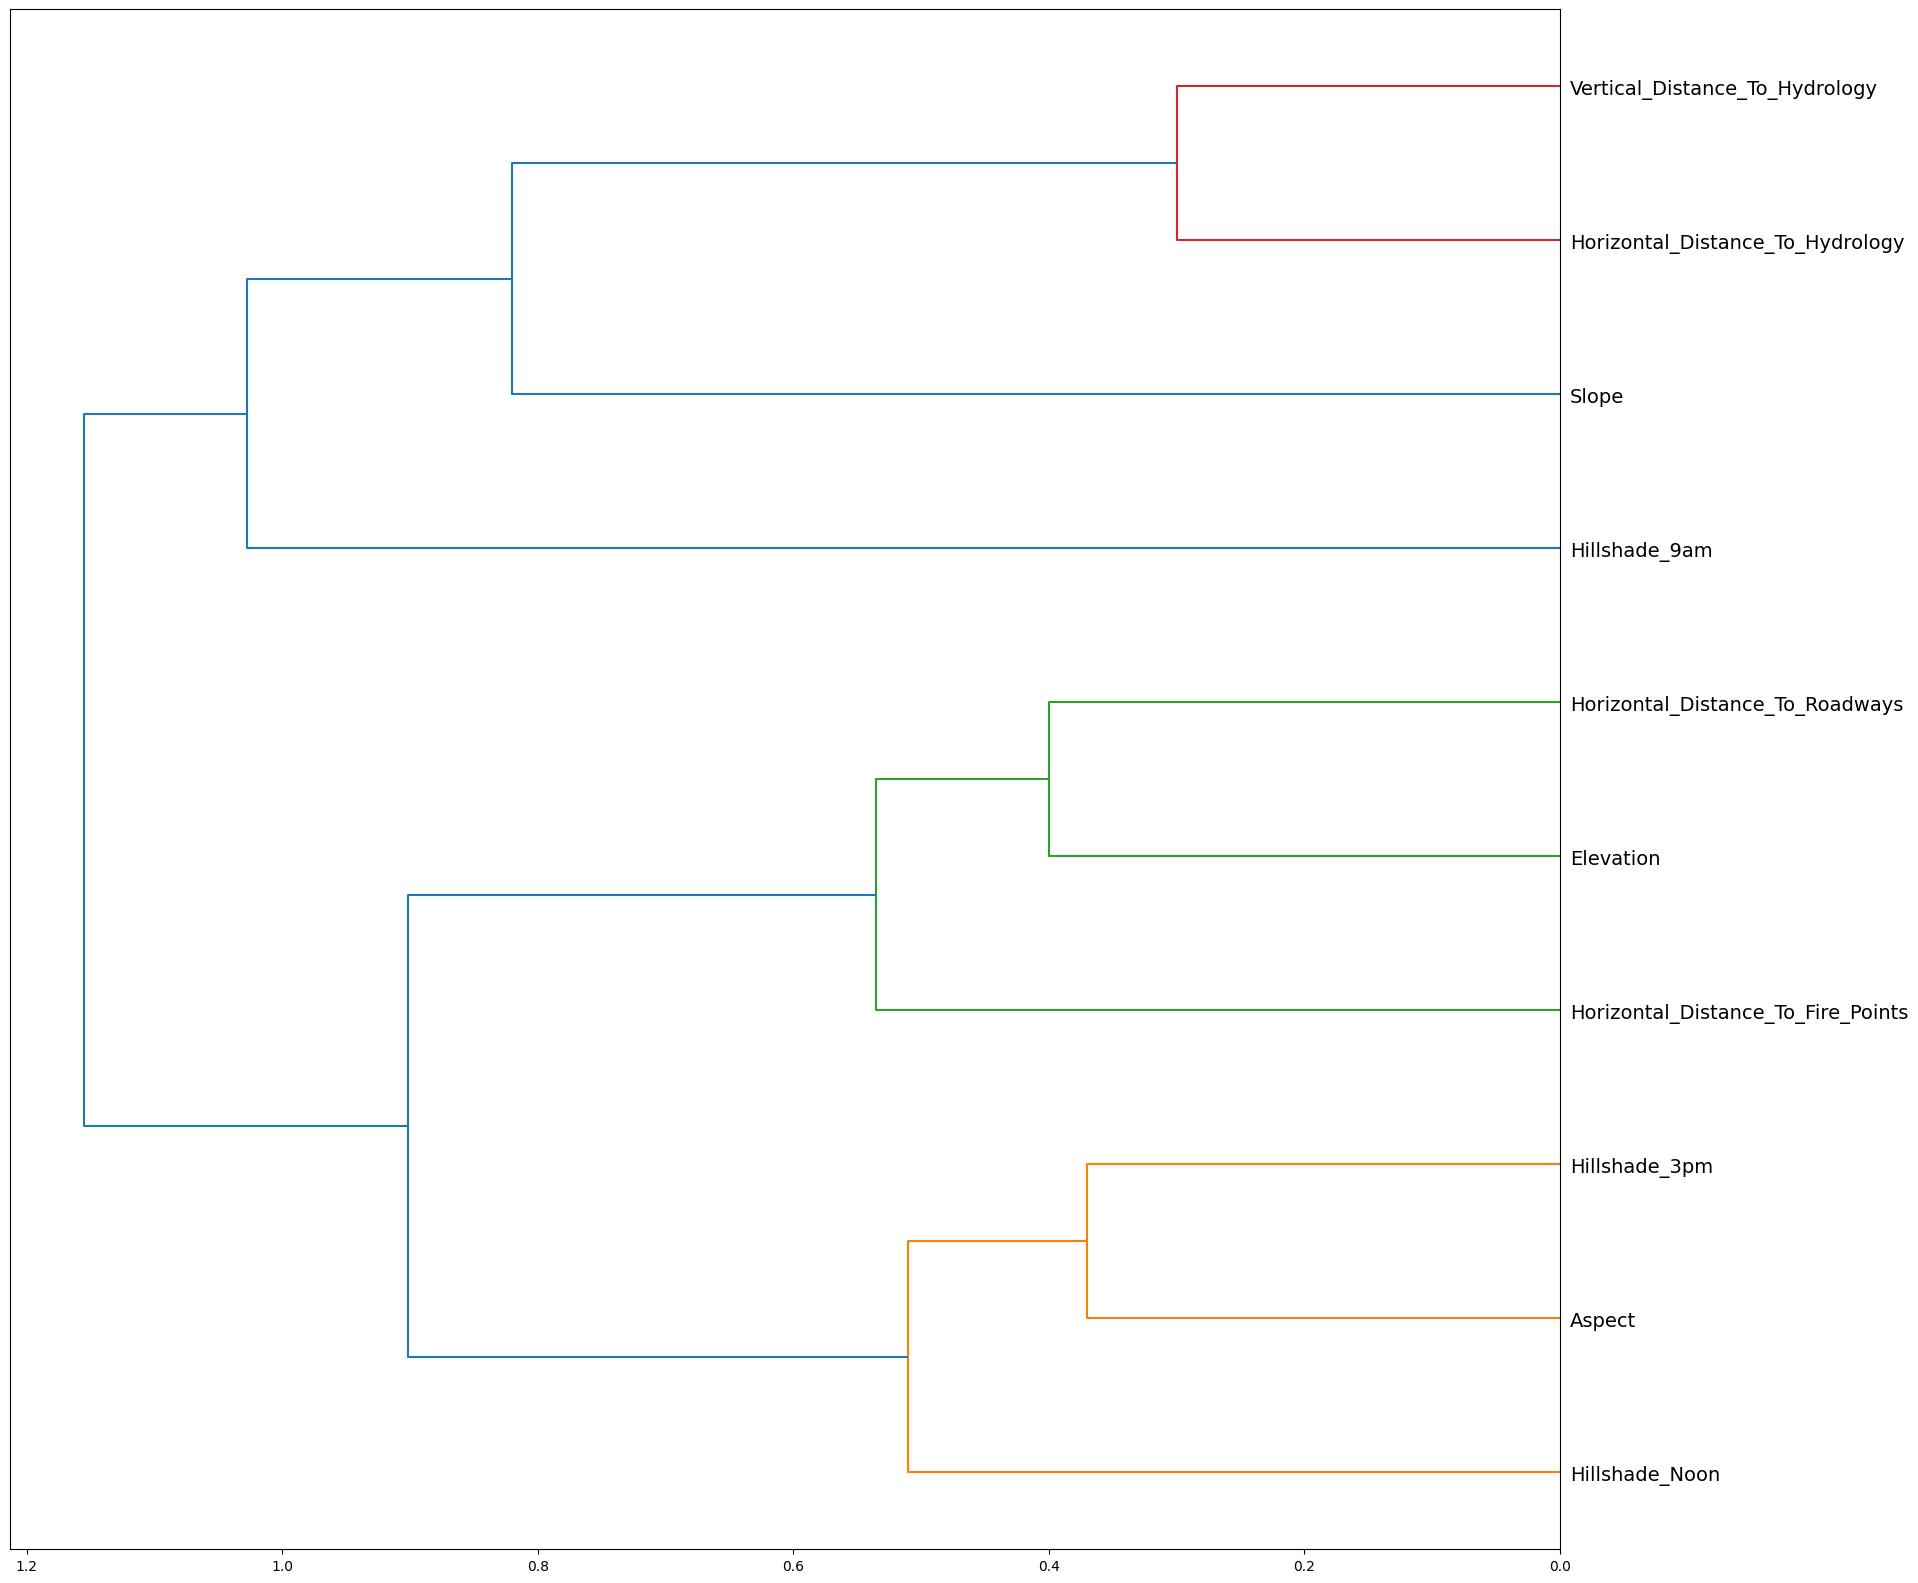

In [157]:
cols = []
for col in df.columns:
    if col[:4] == 'Soil': continue
    if col.split('_')[0] == 'Wilderness': continue
    cols.append(col)
df_copy = df[cols]
df_copy.drop(['Id', 'Cover_Type'], axis=1, inplace=True)
corr = np.round(stats.spearmanr(df_copy).correlation, 2)

plt.figure(figsize=(20,20))
# hc.distance.squareform(1-corr)
hc.dendrogram(hc.linkage(hc.distance.squareform(1-corr), 
                         method='weighted'), 
              labels=df_copy.columns, orientation='left', 
              leaf_font_size=14)
plt.show()

##### 小結
透過第一張圖的分析，我們可以確認大概有幾種feature之間會有相關性<br>

再來我們分成兩部分來做圖分析：分別為區域種類&泥土種類，以及其他feature<br>

透過第二張圖，我們confirm了特定的泥土會跟某些區域種類有關係<br>

透過第三張圖，我們再次confirm了在第一張圖的分析結果中，相關性高的feature組合<br>

# feature engineering

> 特徵工程（Feature engineering）是指在機器學習中對原始數據進行轉換、選擇、創建特徵，以提高機器學習算法的性能和準確度的過程。在機器學習中，特徵是指從數據中提取的有意義的信息，通常用於描述樣本或輸入數據的屬性或特性。

以下是我個人整理出feature engineering流程當中可用的作法：

* filling missing value
    * fill them with `average`, `median`, `distribution`, `zero`, etc.
    * discard
* featrue encoding
    * one-hot encoding
    * frequence encoding
    * target encoding
* standarization
* scaling
    * min-max scaling
* binning
    * for numeric feature
    * for categorical feature
* feature transformation
    * log transformation
* feature creation
    * linear
    * nonlinear
* feature selection
    * filter methods (univariate analysis)
        * pearson correlation
        * chi-square test
    * wrapper methods
        * 向前搜尋法
        * 向後搜尋法
        * 窮舉法
    * embedded methods
    * random search methods
        * Genetic algorithm
        * 退火演算法
* dimensional reduction
    * PCA
    * LDA 

### check missing value

這份資料當中沒有任何的缺失值，所以不需要填補任何的數值<br>
不過還是可以簡短的介紹一下我這段時間的研究，說明我對缺失值填補的看法

* 數值型資料：一般來說，如果數據是常態分佈的話，可以用平均值填補，但是很多時候數據沒但法那麼完美的呈現常態分佈，所以比較好的方法是用中位數填補
* 類別型資料：可以用出現次數，頻率最高的類別作填補(因為一般情況下頻率最高的數據，出現的可能性也最高)

* 當然，上面這兩種填補方式一定沒辦法適用所有情況。例如說當我們以頻率最高的類別進行填補，填補完之後頻率高的類別佔比更加上升，頻率少的資料佔比更加下降。而如果頻率少的資料很重要，填補完還讓數據佔比下降，則會影響預測的結果。所以存在一些機器學習的方法，透過其他完整的資料訓練模型，再透過輸入有缺失值的資料，以模型預測需要填補的欄位。

不過只要是任何形式的缺失值填補，都會讓數據產生噪音。


In [163]:
df_stat

,data types,Missing,unique
Id,int64,0,15120
Elevation,int64,0,1665
Aspect,int64,0,361
Slope,int64,0,52
Horizontal_Distance_To_Hydrology,int64,0,400
Vertical_Distance_To_Hydrology,int64,0,423
Horizontal_Distance_To_Roadways,int64,0,3250
Hillshade_9am,int64,0,176
Hillshade_Noon,int64,0,141
Hillshade_3pm,int64,0,247


### feature encoding

feature encoding是將categorical feature轉換成數值型資料的方法。分成，

* 非監督式編碼：encoding過程當中不需要用到target的資訊
    * one-hot encoding
    * frequence encoding：根據每個類別型特徵的出現頻率，來映射該特徵的每個取值
* 監督式編碼：encoding過程會參考target的資訊
    * target encoding：根據每個類別型特徵的目標變量（target variable）的平均值或其他統計量來映射該特徵的每個取值

這份數據當中，categorical feature有`Wilderness_area`跟`Soil_Type`，我打算保留原來的encoding方式。而Label encoding得到的標籤是有大小區別的，而每一個類別並不應該有大小順序關係；target encoding等監督式encoding方式會加入target的資訊，會受到資料分布的影響，所以我認為保留原來encoding的方式就可以了。

### feature creation

* log transformation/sqrt transformation
    * sqrt transformation會讓數據的variance變小
    * log transformation可以讓數據的偏度降低，使其符合正態分布
* binning：對數值數據分箱
* 透過hierarchy clustering，得到相關性較高的features，用這些feature進行一些組合
    * 相加
    * 相減
    * 單位不同的特徵作加減之前，需要先做min-max scaling

In [166]:
# scaling for feature craetion
# for Aspect, Elevation, Slope, and others
from sklearn.preprocessing import MinMaxScaler
import math
def minmaxscale(data:pd.Series):
    scaler = MinMaxScaler(feature_range=(0,1)).fit([data])
    return scaler.transform([data])[0]

def feature_creation(df:pd.DataFrame):

    df['Hillshade'] = df['Hillshade_3pm'] + df['Hillshade_9am'] + df['Hillshade_Noon']
    df['Distance_To_Hydrology'] = abs(df['Vertical_Distance_To_Hydrology']) + abs(df['Horizontal_Distance_To_Hydrology'])
    df['Distance_Roadways_FirPoints'] = df['Horizontal_Distance_To_Roadways'] + df['Horizontal_Distance_To_Fire_Points']
    df['Distance_Roadways-FirPoints'] = df['Horizontal_Distance_To_Roadways'] - df['Horizontal_Distance_To_Fire_Points']

    df['binned_elev'] = [math.floor(v/50.0) for v in df['Elevation']]
    df['Ele_Hillshade'] = df['Elevation'] - df['Hillshade']
    df['Ele-Hillshade'] = df['Elevation'] + df['Hillshade']

    # Wilderness_Area & Soil_Type
    df['Wilderness_Area1_soil'] = df['Wilderness_Area1'] + df['Soil_Type29']
    df['Wilderness_Area2_soil'] = df['Wilderness_Area2'] + df['Soil_Type40']
    df['Wilderness_Area3_soil'] = df['Wilderness_Area3'] + df['Soil_Type32']
    df['Wilderness_Area4_soil'] = df['Wilderness_Area4'] + df['Soil_Type3'] # 較不顯著

    # Elevation 
    df['Elevation_FirePoint'] = df['Elevation'] + df['Horizontal_Distance_To_Fire_Points']
    df['Elevation-FirePoint'] = df['Elevation'] - df['Horizontal_Distance_To_Fire_Points']

    df['Elevation_Road'] = df['Elevation'] + df['Horizontal_Distance_To_Roadways']
    df['Elevation-Road'] = df['Elevation'] - df['Horizontal_Distance_To_Roadways']

    # Slope
    Slope = minmaxscale(df['Slope'])
    Distance_To_Hydrology = minmaxscale(df['Distance_To_Hydrology'])
    Aspect = minmaxscale(df['Aspect'])
    Hillshade = minmaxscale(df['Hillshade'])

    df['binned_Slope'] = [math.floor(v/2.60) for v in df['Slope']]
    df['Slope_Hydrology'] = Slope + Distance_To_Hydrology
    df['Slope-Hydrology'] = Slope - Distance_To_Hydrology
    df['Slope_Hillshade'] = Slope + Hillshade
    df['Slope-Hillshade'] = Slope - Hillshade
    
    # Aspect
    df['binned_Aspect'] = [math.floor(v/18.0) for v in df['Aspect']]
    df['Aspect_Hillshade'] = Aspect + Hillshade
    df['Aspect-Hillshade'] = Aspect - Hillshade
    
    return df 
df_test = feature_creation(df.copy().drop(['Id'], axis=1))
df_test.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [169]:
len(df_test.columns) # with Cover_Type, Soil_Type7, Soil_Type15

78

### feture selection

feature selection分成以下三個方法：

* filter methods：透過一些簡單的指標，或是一些統計指標，過濾掉一些多餘的特徵，例如
    * 半常數特徵：如果超過一定比例的feature都是一樣的值，可以刪除
    * 皮爾森相關係數法：檢查feature之間的相關性，如果高於閥值就代表feature是多餘的，可以刪除
* 使用wrapper method：以下的方法是搜尋特徵子集合的方法，雖然較為有效，但是花費的時間比較長
    * Sequential Forward Selection
    * Sequential backward Selection
    * Exhaustive selection

##### Sequential Forward Selection
1. 一開始設定要選擇的feature數量，以及用來估計feature分數的模型，通常會是之後訓練用的模型
2. 依序遍歷所有特徵，並將每一個feature加入一個集合當中，每一個集合被稱為特徵子集合
3. 對於每一個待選的集合使用預先選擇的模型進行評分，並選出最好的集合。剩下的feature則還沒被選中
4. 依序將沒有被選中的feature加入選中的特徵集合當中，並重複步驟3直到結束

考量演算法的時間複雜度以及機器學習模型運行的時間，這個搜索的過程會耗費非常久的時間，如果設定的feature數量較多，更是不可能完成，所以最後無法使用這個演算法完成feature selection

In [170]:
# 提取預訓練模型
from joblib import load 
xgb_load = load('model/xgb.joblib')

In [9]:
def feature_selection(df:pd.DataFrame, k_features:int, cv:int):
    sns.set_style('darkgrid')
    data, target = df.drop(['Cover_Type'], axis=1), df['Cover_Type']
    x1, x2, y1, y2 = train_test_split(data, target)
    y1 -= 1 # map target Cover_Type 1~7 to 0~6
    sfs = SequentialFeatureSelector(
                    estimator = xgb_load,
                    k_features = k_features, 
                    forward=True, 
                    floating=False,
                    scoring='accuracy',
                    cv=5,
                    verbose=2)
    sfs.fit(x1, y1)
    fig, axes = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
    print(sfs.subsets_)
    return sfs
# df_copy = feature_creation(df.copy().drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis=1))
# sfs = feature_selection(df_copy, 75, 5)
# print(sfs.subsets_)

### dimensional reduction
免不了的資訊損失，會讓預測準確度下降
* PCA
* LDA 

In [176]:
data, target = feature_creation(df.drop(['Cover_Type', 'Soil_Type7', 'Soil_Type15'], axis=1)), df['Cover_Type']
x1, x2, y1, y2 = train_test_split(data, target)
y1 -= 1
y2 -= 1

In [181]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=70)
pca.fit(x1, x2)
x1_transformed = pca.transform(x1)
x2_transformed = pca.transform(x2)
xgb_test = train('xgb', x1_transformed, x2_transformed, y1, y2)
score(xgb_test, x1_transformed, x2_transformed, y1, y2)

c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train acc:  1.0
test acc:  0.8634920634920635
cross validation score:  0.7880952380952381


In [182]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis(n_components=6)
LDA.fit(x1, y1)
x1_transformed = LDA.transform(x1)
x2_transformed = LDA.transform(x2)
xgb_test = train('xgb', x1_transformed, x2_transformed, y1, y2)
score(xgb_test, x1_transformed, x2_transformed, y1, y2)

c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train acc:  0.9470017636684304
test acc:  0.7666666666666667
cross validation score:  0.7214285714285714


### training
* 使用基於梯度提升(Gradient boosting)的模型
* 使用基於樹的模型

In [183]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

In [5]:
def train(method:str, x1, x2, y1, y2, param=None):    
    # data, target = df.drop(['Cover_Type'], axis=1), df['Cover_Type']
    # x1, x2, y1, y2 = train_test_split(data, target, random_state=42)
    # y1 -= 1
    # y2 -= 1
    
    if method == 'xgb':
        eval_set = [(x1, y1), (x2, y2)]
        if param: xgb = XGBClassifier(**param)
        else: xgb = XGBClassifier(eval_metric=['merror', 'mlogloss'])
        xgb.fit(x1, y1, eval_set = eval_set, verbose=False, early_stopping_rounds=10)
        return xgb
    elif method == 'rf':
        if param:
            rf = RandomForestClassifier(**param)
        else:
            rf = RandomForestClassifier()
        rf.fit(x1, y1)
        return rf
    elif method == 'hgb':
        if param:
            hgb = HistGradientBoostingClassifier(**param)
        else:
            hgb = HistGradientBoostingClassifier()
        hgb.fit(x1, y1)
        return hgb
    elif method == 'ext':
        if param:
            ext = ExtraTreesClassifier(**param)
        else:
            ext = ExtraTreesClassifier()
        ext.fit(x1, y1)
        return ext
    elif method == 'LGBM':
        eval_set = [(x1, y1), (x2, y2)]
        if param: lgbm = LGBMClassifier(**param)
        else:lgbm = LGBMClassifier()
        lgbm.fit(x1, y1, eval_set = eval_set, verbose=False, early_stopping_rounds=10)
        return lgbm
    else:
        print('method error!')

In [11]:
def plot_error_xgb(xgb):
    results = xgb.evals_result()
    sns.set_style('darkgrid')
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
    plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()

In [6]:
def score(model, x1, x2, y1, y2):
    pred = model.predict(x1)
    print('train acc: ', accuracy_score(y1, pred))
    pred = model.predict(x2)
    print('test acc: ', accuracy_score(y2, pred))
    print('cross validation score: ',np.mean(cross_val_score(model, x2, y2, cv=5)))
    # classification report......
# model = {
#     'et':et,
#     'rf':rf,
#     'knn':knn,
#     'hgb':hgb,
# }
# for m in model:
#     print('for model {} : '.format(m))
#     score(model[m], x1, x2, y1, y2)
#     print('-'*20)

In [15]:
model = {
    'xgb': None,
    'rf':None,
    'LGBM':None,
    'ext':None
}
for name in model:
    print(name)
    model[name] = train(method=name, x1=x1, x2=x2, y1=y1, y2=y2)
    score(model[name], x1, x2, y1, y2)
    print('-'*30)

xgb


c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train acc:  0.9982363315696648
test acc:  0.876984126984127
cross validation score:  0.8013227513227512
------------------------------
rf
train acc:  1.0
test acc:  0.8809523809523809
cross validation score:  0.8126984126984127
------------------------------
LGBM


c:\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


train acc:  0.9970899470899471
test acc:  0.8732804232804233
cross validation score:  0.808994708994709
------------------------------
ext
train acc:  1.0
test acc:  0.8915343915343915
cross validation score:  0.8190476190476191
------------------------------


### hyperparameter tuning

In [13]:
import optuna
import warnings
warnings.filterwarnings('ignore')

In [7]:
df_copy_last = feature_creation(df.copy().drop(['Id'], axis=1))
data, target = df_copy_last.drop(['Cover_Type', 'Soil_Type7', 'Soil_Type15'], axis=1), df['Cover_Type']
x1_, x2_, y1_, y2_ = train_test_split(data, target, random_state=42)
y1_ -= 1
y2_ -= 1

In [32]:
score(xgb_load, x1_, x2_, y1_, y2_)

train acc:  0.9973544973544973
test acc:  0.8764550264550265
cross validation score:  0.8145502645502646


In [43]:
print(x1.shape)
print(x2.shape)
print(y1.shape)
print(y1.shape)

(11340, 75)
(3780, 75)
(11340,)
(11340,)


In [52]:
# Tuning xgboost
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(x1, y1)

    # Make predictions
    # y_pred = optuna_model.predict(x2)

    # Evaluate predictions
    # accuracy = accuracy_score(y2, y_pred)
    
    accuracy = np.mean(cross_validate(optuna_model, x2, y2, scoring='accuracy', cv=5)['test_score'])
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

xgb_param = trial.params

[I 2023-04-08 17:01:32,223] A new study created in memory with name: no-name-741484b6-6c80-4257-8f69-49805777ca5e
[I 2023-04-08 17:01:35,103] Trial 0 finished with value: 0.7357142857142858 and parameters: {'max_depth': 2, 'learning_rate': 0.13071242919310125, 'n_estimators': 121, 'min_child_weight': 2, 'gamma': 0.00014133478207314053, 'subsample': 0.25325976284598345, 'colsample_bytree': 0.09552959058422467, 'reg_alpha': 2.406399269660839e-07, 'reg_lambda': 3.174146712989705e-08}. Best is trial 0 with value: 0.7357142857142858.
[I 2023-04-08 17:01:49,973] Trial 1 finished with value: 0.798148148148148 and parameters: {'max_depth': 3, 'learning_rate': 0.20657053818923735, 'n_estimators': 308, 'min_child_weight': 6, 'gamma': 4.285274063006415e-08, 'subsample': 0.8162981816054945, 'colsample_bytree': 0.39980274987654096, 'reg_alpha': 0.6902552673139254, 'reg_lambda': 1.9628804517564726e-06}. Best is trial 1 with value: 0.798148148148148.
[I 2023-04-08 17:01:52,948] Trial 2 finished with 

Accuracy: 0.8145502645502646
Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.05143534119636937, 'n_estimators': 254, 'min_child_weight': 1, 'gamma': 0.01662600688343986, 'subsample': 0.7950110636187313, 'colsample_bytree': 0.34610462100249284, 'reg_alpha': 0.021905578136565525, 'reg_lambda': 3.319408513833762e-08}


In [35]:
# Tuning random forest 
def objective(trial:optuna.trial.Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
    }

    optuna_model = RandomForestClassifier(**params)
    optuna_model.fit(x1, y1)

    # Make predictions
    # y_pred = optuna_model.predict(x2)

    # Evaluate predictions
    # accuracy = accuracy_score(y2, y_pred)
    
    accuracy = np.mean(cross_validate(optuna_model, x2, y2, scoring='accuracy', cv=5)['test_score'])
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

rf_param = trial.params

[I 2023-04-08 01:59:51,180] A new study created in memory with name: no-name-35ddfaa0-ca42-4c39-bc41-93333cf381f9
[I 2023-04-08 02:00:12,461] Trial 0 finished with value: 0.7158730158730158 and parameters: {'n_estimators': 503, 'max_depth': 47, 'min_samples_split': 37, 'min_samples_leaf': 36}. Best is trial 0 with value: 0.7158730158730158.
[I 2023-04-08 02:01:08,931] Trial 1 finished with value: 0.758994708994709 and parameters: {'n_estimators': 988, 'max_depth': 30, 'min_samples_split': 48, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.758994708994709.
[I 2023-04-08 02:01:54,535] Trial 2 finished with value: 0.7619047619047619 and parameters: {'n_estimators': 782, 'max_depth': 20, 'min_samples_split': 39, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7619047619047619.
[I 2023-04-08 02:02:21,395] Trial 3 finished with value: 0.7224867724867724 and parameters: {'n_estimators': 599, 'max_depth': 21, 'min_samples_split': 131, 'min_samples_leaf': 3}. Best is trial 2 with v

Accuracy: 0.812962962962963
Best hyperparameters: {'n_estimators': 367, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [36]:
# Tuning extra tree
def objective(trial:optuna.trial.Trial):

        random_state = 42
        n_jobs = -1
        max_depth = trial.suggest_int("max_depth", 80, 120)
        n_estimators = trial.suggest_int("n_estimators", 80, 120)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    

        classifier_obj = ExtraTreesClassifier( 
            random_state      = random_state,
            n_jobs            = n_jobs,
            max_depth         = max_depth,
            n_estimators      = n_estimators,
            min_samples_split = min_samples_split,
            min_samples_leaf  = min_samples_leaf)

        result = np.mean(cross_validate(classifier_obj, x2, y2, scoring='accuracy', cv=5)['test_score'])
    
        return result


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

ext_param = trial.params

[I 2023-04-08 02:45:51,085] A new study created in memory with name: no-name-ca4a7830-2466-4f9a-a6ee-c0532e571041
[I 2023-04-08 02:45:56,308] Trial 0 finished with value: 0.8023809523809524 and parameters: {'max_depth': 99, 'n_estimators': 88, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8023809523809524.
[I 2023-04-08 02:45:57,668] Trial 1 finished with value: 0.7862433862433863 and parameters: {'max_depth': 115, 'n_estimators': 81, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8023809523809524.
[I 2023-04-08 02:45:59,183] Trial 2 finished with value: 0.7674603174603174 and parameters: {'max_depth': 120, 'n_estimators': 92, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8023809523809524.
[I 2023-04-08 02:46:00,996] Trial 3 finished with value: 0.8005291005291006 and parameters: {'max_depth': 103, 'n_estimators': 94, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value:

Accuracy: 0.8264550264550264
Best hyperparameters: {'max_depth': 106, 'n_estimators': 91, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [37]:
# Tuning LGBM
optuna.logging.set_verbosity(optuna.logging.INFO) 

def objective(trial:optuna.trial.Trial):
    param_grid = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = LGBMClassifier(**param_grid)
    model.fit(
        x1,
        y1,
        eval_set=[(x2, y2)],
        early_stopping_rounds=100,
        verbose=False
    )
    result = np.mean(cross_validate(model, x2, y2, scoring='accuracy', cv=5)['test_score'])
    
    return result

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

lgbm_param = trial.params

[I 2023-04-08 02:48:55,921] A new study created in memory with name: no-name-4d50207c-757a-42b8-9d1a-6e1bc3da85aa


[LightGBM] [Warning] feature_fraction is set=0.7826711695188648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7826711695188648
[LightGBM] [Warning] lambda_l1 is set=0.09566301005985943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09566301005985943
[LightGBM] [Warning] bagging_fraction is set=0.46131867860931386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46131867860931386
[LightGBM] [Warning] lambda_l2 is set=0.02542165926038896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02542165926038896
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7826711695188648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7826711695188648
[LightGBM] [Warning] lambda_l1 is set=0.09566301005985943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09566301005985943
[LightGBM] [Warning] bagging_

[I 2023-04-08 02:48:59,229] Trial 0 finished with value: 0.7883597883597885 and parameters: {'lambda_l1': 0.09566301005985943, 'lambda_l2': 0.02542165926038896, 'num_leaves': 244, 'feature_fraction': 0.7826711695188648, 'bagging_fraction': 0.46131867860931386, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 0 with value: 0.7883597883597885.


[LightGBM] [Warning] feature_fraction is set=0.662778416927765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.662778416927765
[LightGBM] [Warning] lambda_l1 is set=5.718225707000175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.718225707000175e-05
[LightGBM] [Warning] bagging_fraction is set=0.763589548244235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763589548244235
[LightGBM] [Warning] lambda_l2 is set=0.001131093436043038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001131093436043038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.662778416927765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.662778416927765
[LightGBM] [Warning] lambda_l1 is set=5.718225707000175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.718225707000175e-05
[LightGBM] [Warning] baggin

[I 2023-04-08 02:49:03,637] Trial 1 finished with value: 0.8034391534391535 and parameters: {'lambda_l1': 5.718225707000175e-05, 'lambda_l2': 0.001131093436043038, 'num_leaves': 201, 'feature_fraction': 0.662778416927765, 'bagging_fraction': 0.763589548244235, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 1 with value: 0.8034391534391535.


[LightGBM] [Warning] feature_fraction is set=0.543510924119055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.543510924119055
[LightGBM] [Warning] lambda_l1 is set=0.0008840406139546618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008840406139546618
[LightGBM] [Warning] bagging_fraction is set=0.9021642614863619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9021642614863619
[LightGBM] [Warning] lambda_l2 is set=0.000432517273612192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000432517273612192
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.543510924119055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.543510924119055
[LightGBM] [Warning] lambda_l1 is set=0.0008840406139546618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008840406139546618
[LightGBM] [Warning] bagg

[I 2023-04-08 02:49:07,845] Trial 2 finished with value: 0.8026455026455025 and parameters: {'lambda_l1': 0.0008840406139546618, 'lambda_l2': 0.000432517273612192, 'num_leaves': 89, 'feature_fraction': 0.543510924119055, 'bagging_fraction': 0.9021642614863619, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 1 with value: 0.8034391534391535.


[LightGBM] [Warning] feature_fraction is set=0.9322892149107842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9322892149107842
[LightGBM] [Warning] lambda_l1 is set=0.006781119920482392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006781119920482392
[LightGBM] [Warning] bagging_fraction is set=0.9857832232866371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9857832232866371
[LightGBM] [Warning] lambda_l2 is set=4.8208070778352976e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8208070778352976e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9322892149107842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9322892149107842
[LightGBM] [Warning] lambda_l1 is set=0.006781119920482392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006781119920482392
[LightGBM] [Warning] 

[I 2023-04-08 02:49:18,352] Trial 3 finished with value: 0.8066137566137567 and parameters: {'lambda_l1': 0.006781119920482392, 'lambda_l2': 4.8208070778352976e-05, 'num_leaves': 128, 'feature_fraction': 0.9322892149107842, 'bagging_fraction': 0.9857832232866371, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 3 with value: 0.8066137566137567.


[LightGBM] [Warning] feature_fraction is set=0.5102516761358729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102516761358729
[LightGBM] [Warning] lambda_l1 is set=2.6573588307768238e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6573588307768238e-06
[LightGBM] [Warning] bagging_fraction is set=0.8003011706360933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8003011706360933
[LightGBM] [Warning] lambda_l2 is set=0.017610997867409516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017610997867409516
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5102516761358729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102516761358729
[LightGBM] [Warning] lambda_l1 is set=2.6573588307768238e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6573588307768238e-06
[LightGBM] [Warni

[I 2023-04-08 02:49:23,327] Trial 4 finished with value: 0.8063492063492064 and parameters: {'lambda_l1': 2.6573588307768238e-06, 'lambda_l2': 0.017610997867409516, 'num_leaves': 235, 'feature_fraction': 0.5102516761358729, 'bagging_fraction': 0.8003011706360933, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 3 with value: 0.8066137566137567.


[LightGBM] [Warning] feature_fraction is set=0.8286104460645205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8286104460645205
[LightGBM] [Warning] lambda_l1 is set=6.232370379375495e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.232370379375495e-06
[LightGBM] [Warning] bagging_fraction is set=0.8781235321352139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8781235321352139
[LightGBM] [Warning] lambda_l2 is set=0.13318591824299394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13318591824299394
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8286104460645205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8286104460645205
[LightGBM] [Warning] lambda_l1 is set=6.232370379375495e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.232370379375495e-06
[LightGBM] [Warning] ba

[I 2023-04-08 02:49:31,812] Trial 5 finished with value: 0.8097883597883598 and parameters: {'lambda_l1': 6.232370379375495e-06, 'lambda_l2': 0.13318591824299394, 'num_leaves': 90, 'feature_fraction': 0.8286104460645205, 'bagging_fraction': 0.8781235321352139, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 5 with value: 0.8097883597883598.


[LightGBM] [Warning] feature_fraction is set=0.8048175477996371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8048175477996371
[LightGBM] [Warning] lambda_l1 is set=2.6271882428795e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6271882428795e-07
[LightGBM] [Warning] bagging_fraction is set=0.49496693051852275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49496693051852275
[LightGBM] [Warning] lambda_l2 is set=0.01486289946721042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01486289946721042
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8048175477996371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8048175477996371
[LightGBM] [Warning] lambda_l1 is set=2.6271882428795e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6271882428795e-07
[LightGBM] [Warning] bagging_

[I 2023-04-08 02:49:44,573] Trial 6 finished with value: 0.7994708994708994 and parameters: {'lambda_l1': 2.6271882428795e-07, 'lambda_l2': 0.01486289946721042, 'num_leaves': 174, 'feature_fraction': 0.8048175477996371, 'bagging_fraction': 0.49496693051852275, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 5 with value: 0.8097883597883598.


[LightGBM] [Warning] feature_fraction is set=0.4748950082159039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4748950082159039
[LightGBM] [Warning] lambda_l1 is set=8.772272953129828e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.772272953129828e-06
[LightGBM] [Warning] bagging_fraction is set=0.9017533809429925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9017533809429925
[LightGBM] [Warning] lambda_l2 is set=0.0044673454593914174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0044673454593914174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4748950082159039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4748950082159039
[LightGBM] [Warning] lambda_l1 is set=8.772272953129828e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.772272953129828e-06
[LightGBM] [Warning

[I 2023-04-08 02:49:48,882] Trial 7 finished with value: 0.802116402116402 and parameters: {'lambda_l1': 8.772272953129828e-06, 'lambda_l2': 0.0044673454593914174, 'num_leaves': 178, 'feature_fraction': 0.4748950082159039, 'bagging_fraction': 0.9017533809429925, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 5 with value: 0.8097883597883598.


[LightGBM] [Warning] feature_fraction is set=0.8470021811958577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8470021811958577
[LightGBM] [Warning] lambda_l1 is set=0.20193433091291577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20193433091291577
[LightGBM] [Warning] bagging_fraction is set=0.8234048427887817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8234048427887817
[LightGBM] [Warning] lambda_l2 is set=8.54830059600185e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.54830059600185e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8470021811958577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8470021811958577
[LightGBM] [Warning] lambda_l1 is set=0.20193433091291577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20193433091291577
[LightGBM] [Warning] bagging_

[I 2023-04-08 02:49:53,999] Trial 8 finished with value: 0.8047619047619048 and parameters: {'lambda_l1': 0.20193433091291577, 'lambda_l2': 8.54830059600185e-06, 'num_leaves': 96, 'feature_fraction': 0.8470021811958577, 'bagging_fraction': 0.8234048427887817, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 5 with value: 0.8097883597883598.


[LightGBM] [Warning] feature_fraction is set=0.4250881726449621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4250881726449621
[LightGBM] [Warning] lambda_l1 is set=0.0042305527298401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0042305527298401
[LightGBM] [Warning] bagging_fraction is set=0.5610677730083711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5610677730083711
[LightGBM] [Warning] lambda_l2 is set=0.021172250361007127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021172250361007127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4250881726449621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4250881726449621
[LightGBM] [Warning] lambda_l1 is set=0.0042305527298401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0042305527298401
[LightGBM] [Warning] bagging_frac

[I 2023-04-08 02:50:05,379] Trial 9 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.0042305527298401, 'lambda_l2': 0.021172250361007127, 'num_leaves': 233, 'feature_fraction': 0.4250881726449621, 'bagging_fraction': 0.5610677730083711, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.4116135457818833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4116135457818833
[LightGBM] [Warning] lambda_l1 is set=7.513924194467937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.513924194467937
[LightGBM] [Warning] bagging_fraction is set=0.6248585570101698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6248585570101698
[LightGBM] [Warning] lambda_l2 is set=8.359374291905722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.359374291905722
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4116135457818833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4116135457818833
[LightGBM] [Warning] lambda_l1 is set=7.513924194467937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.513924194467937
[LightGBM] [Warning] bagging_fraction is se

[I 2023-04-08 02:50:07,192] Trial 10 finished with value: 0.7492063492063492 and parameters: {'lambda_l1': 7.513924194467937, 'lambda_l2': 8.359374291905722, 'num_leaves': 11, 'feature_fraction': 0.4116135457818833, 'bagging_fraction': 0.6248585570101698, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.650035211986631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.650035211986631
[LightGBM] [Warning] lambda_l1 is set=1.986958715271727e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.986958715271727e-08
[LightGBM] [Warning] bagging_fraction is set=0.6476237899702472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6476237899702472
[LightGBM] [Warning] lambda_l2 is set=1.4821391409773353e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4821391409773353e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.650035211986631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.650035211986631
[LightGBM] [Warning] lambda_l1 is set=1.986958715271727e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.986958715271727e-08
[LightGBM] [Warning] 

[I 2023-04-08 02:50:13,149] Trial 11 finished with value: 0.8023809523809524 and parameters: {'lambda_l1': 1.986958715271727e-08, 'lambda_l2': 1.4821391409773353e-07, 'num_leaves': 38, 'feature_fraction': 0.650035211986631, 'bagging_fraction': 0.6476237899702472, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.592717675041889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592717675041889
[LightGBM] [Warning] lambda_l1 is set=0.00013416899835990508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013416899835990508
[LightGBM] [Warning] bagging_fraction is set=0.5851562973580166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5851562973580166
[LightGBM] [Warning] lambda_l2 is set=1.0084721278403097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0084721278403097
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.592717675041889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592717675041889
[LightGBM] [Warning] lambda_l1 is set=0.00013416899835990508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013416899835990508
[LightGBM] [Warning] bagg

[I 2023-04-08 02:50:22,149] Trial 12 finished with value: 0.8026455026455027 and parameters: {'lambda_l1': 0.00013416899835990508, 'lambda_l2': 1.0084721278403097, 'num_leaves': 82, 'feature_fraction': 0.592717675041889, 'bagging_fraction': 0.5851562973580166, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.730005748220355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730005748220355
[LightGBM] [Warning] lambda_l1 is set=0.002585174854780154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002585174854780154
[LightGBM] [Warning] bagging_fraction is set=0.40197266726214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40197266726214
[LightGBM] [Warning] lambda_l2 is set=0.28311723900223146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28311723900223146
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.730005748220355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730005748220355
[LightGBM] [Warning] lambda_l1 is set=0.002585174854780154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002585174854780154
[LightGBM] [Warning] bagging_fracti

[I 2023-04-08 02:50:26,748] Trial 13 finished with value: 0.7936507936507936 and parameters: {'lambda_l1': 0.002585174854780154, 'lambda_l2': 0.28311723900223146, 'num_leaves': 137, 'feature_fraction': 0.730005748220355, 'bagging_fraction': 0.40197266726214, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.4044793332357494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4044793332357494
[LightGBM] [Warning] lambda_l1 is set=1.723512203422746e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.723512203422746e-05
[LightGBM] [Warning] bagging_fraction is set=0.6972467339622795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972467339622795
[LightGBM] [Warning] lambda_l2 is set=0.12019700394744123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12019700394744123
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4044793332357494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4044793332357494
[LightGBM] [Warning] lambda_l1 is set=1.723512203422746e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.723512203422746e-05
[LightGBM] [Warning] ba

[I 2023-04-08 02:50:33,417] Trial 14 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 1.723512203422746e-05, 'lambda_l2': 0.12019700394744123, 'num_leaves': 61, 'feature_fraction': 0.4044793332357494, 'bagging_fraction': 0.6972467339622795, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.4029091527427224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029091527427224
[LightGBM] [Warning] lambda_l1 is set=0.00011272393277779296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011272393277779296
[LightGBM] [Warning] bagging_fraction is set=0.7071544470704484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7071544470704484
[LightGBM] [Warning] lambda_l2 is set=5.448894312711006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.448894312711006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4029091527427224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029091527427224
[LightGBM] [Warning] lambda_l1 is set=0.00011272393277779296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011272393277779296
[LightGBM] [Warning] ba

[I 2023-04-08 02:50:37,217] Trial 15 finished with value: 0.7917989417989418 and parameters: {'lambda_l1': 0.00011272393277779296, 'lambda_l2': 5.448894312711006, 'num_leaves': 43, 'feature_fraction': 0.4029091527427224, 'bagging_fraction': 0.7071544470704484, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.46380799645786464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46380799645786464
[LightGBM] [Warning] lambda_l1 is set=0.01035708937518534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01035708937518534
[LightGBM] [Warning] bagging_fraction is set=0.5758772152034837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5758772152034837
[LightGBM] [Warning] lambda_l2 is set=0.2858757351254177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2858757351254177
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46380799645786464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46380799645786464
[LightGBM] [Warning] lambda_l1 is set=0.01035708937518534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01035708937518534
[LightGBM] [Warning] bagging_

[I 2023-04-08 02:50:44,075] Trial 16 finished with value: 0.8066137566137567 and parameters: {'lambda_l1': 0.01035708937518534, 'lambda_l2': 0.2858757351254177, 'num_leaves': 130, 'feature_fraction': 0.46380799645786464, 'bagging_fraction': 0.5758772152034837, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.40121403554354185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40121403554354185
[LightGBM] [Warning] lambda_l1 is set=0.0004975089258344968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004975089258344968
[LightGBM] [Warning] bagging_fraction is set=0.6946125037083857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6946125037083857
[LightGBM] [Warning] lambda_l2 is set=0.0028041131971736073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028041131971736073
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40121403554354185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40121403554354185
[LightGBM] [Warning] lambda_l1 is set=0.0004975089258344968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004975089258344968
[LightGBM] [War

[I 2023-04-08 02:50:49,454] Trial 17 finished with value: 0.8007936507936508 and parameters: {'lambda_l1': 0.0004975089258344968, 'lambda_l2': 0.0028041131971736073, 'num_leaves': 213, 'feature_fraction': 0.40121403554354185, 'bagging_fraction': 0.6946125037083857, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.5588688553733502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588688553733502
[LightGBM] [Warning] lambda_l1 is set=2.0744416486985636e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0744416486985636e-05
[LightGBM] [Warning] bagging_fraction is set=0.5439963903973246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5439963903973246
[LightGBM] [Warning] lambda_l2 is set=0.05032777348235619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05032777348235619
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5588688553733502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588688553733502
[LightGBM] [Warning] lambda_l1 is set=2.0744416486985636e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0744416486985636e-05
[LightGBM] [Warning

[I 2023-04-08 02:50:56,217] Trial 18 finished with value: 0.8071428571428572 and parameters: {'lambda_l1': 2.0744416486985636e-05, 'lambda_l2': 0.05032777348235619, 'num_leaves': 57, 'feature_fraction': 0.5588688553733502, 'bagging_fraction': 0.5439963903973246, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.592719117920095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592719117920095
[LightGBM] [Warning] lambda_l1 is set=1.2010233524697745e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2010233524697745e-06
[LightGBM] [Warning] bagging_fraction is set=0.6500348190533964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6500348190533964
[LightGBM] [Warning] lambda_l2 is set=0.90411661456186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.90411661456186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.592719117920095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592719117920095
[LightGBM] [Warning] lambda_l1 is set=1.2010233524697745e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2010233524697745e-06
[LightGBM] [Warning] bagging_

[I 2023-04-08 02:50:57,643] Trial 19 finished with value: 0.7746031746031746 and parameters: {'lambda_l1': 1.2010233524697745e-06, 'lambda_l2': 0.90411661456186, 'num_leaves': 5, 'feature_fraction': 0.592719117920095, 'bagging_fraction': 0.6500348190533964, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.45072975282351924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45072975282351924
[LightGBM] [Warning] lambda_l1 is set=0.0005061541992367704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005061541992367704
[LightGBM] [Warning] bagging_fraction is set=0.7231119899370684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231119899370684
[LightGBM] [Warning] lambda_l2 is set=0.0001035599330864769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001035599330864769
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.45072975282351924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45072975282351924
[LightGBM] [Warning] lambda_l1 is set=0.0005061541992367704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005061541992367704
[LightGBM] [War

[I 2023-04-08 02:51:04,946] Trial 20 finished with value: 0.8068783068783068 and parameters: {'lambda_l1': 0.0005061541992367704, 'lambda_l2': 0.0001035599330864769, 'num_leaves': 152, 'feature_fraction': 0.45072975282351924, 'bagging_fraction': 0.7231119899370684, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.5027602721346837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5027602721346837
[LightGBM] [Warning] lambda_l1 is set=1.6456162097150172e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6456162097150172e-05
[LightGBM] [Warning] bagging_fraction is set=0.6742194628237079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6742194628237079
[LightGBM] [Warning] lambda_l2 is set=0.139895393580591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.139895393580591
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5027602721346837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5027602721346837
[LightGBM] [Warning] lambda_l1 is set=1.6456162097150172e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6456162097150172e-05
[LightGBM] [Warning] ba

[I 2023-04-08 02:51:11,408] Trial 21 finished with value: 0.8089947089947088 and parameters: {'lambda_l1': 1.6456162097150172e-05, 'lambda_l2': 0.139895393580591, 'num_leaves': 102, 'feature_fraction': 0.5027602721346837, 'bagging_fraction': 0.6742194628237079, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 9 with value: 0.8111111111111111.


[LightGBM] [Warning] feature_fraction is set=0.4582612506967945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4582612506967945
[LightGBM] [Warning] lambda_l1 is set=1.0802372458363967e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0802372458363967e-06
[LightGBM] [Warning] bagging_fraction is set=0.747560858701594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.747560858701594
[LightGBM] [Warning] lambda_l2 is set=0.07272161490350024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07272161490350024
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4582612506967945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4582612506967945
[LightGBM] [Warning] lambda_l1 is set=1.0802372458363967e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0802372458363967e-06
[LightGBM] [Warning] 

[I 2023-04-08 02:51:20,250] Trial 22 finished with value: 0.8134920634920635 and parameters: {'lambda_l1': 1.0802372458363967e-06, 'lambda_l2': 0.07272161490350024, 'num_leaves': 66, 'feature_fraction': 0.4582612506967945, 'bagging_fraction': 0.747560858701594, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 22 with value: 0.8134920634920635.


[LightGBM] [Warning] feature_fraction is set=0.451705098135158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.451705098135158
[LightGBM] [Warning] lambda_l1 is set=5.565729290539648e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.565729290539648e-07
[LightGBM] [Warning] bagging_fraction is set=0.7300378159334745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7300378159334745
[LightGBM] [Warning] lambda_l2 is set=0.008254285012937073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008254285012937073
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.451705098135158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.451705098135158
[LightGBM] [Warning] lambda_l1 is set=5.565729290539648e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.565729290539648e-07
[LightGBM] [Warning] bagg

[I 2023-04-08 02:51:29,438] Trial 23 finished with value: 0.8145502645502646 and parameters: {'lambda_l1': 5.565729290539648e-07, 'lambda_l2': 0.008254285012937073, 'num_leaves': 63, 'feature_fraction': 0.451705098135158, 'bagging_fraction': 0.7300378159334745, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 23 with value: 0.8145502645502646.


[LightGBM] [Warning] feature_fraction is set=0.4658695148913312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4658695148913312
[LightGBM] [Warning] lambda_l1 is set=2.2792014493720562e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2792014493720562e-07
[LightGBM] [Warning] bagging_fraction is set=0.6042664788396462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6042664788396462
[LightGBM] [Warning] lambda_l2 is set=0.005115209672201005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005115209672201005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4658695148913312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4658695148913312
[LightGBM] [Warning] lambda_l1 is set=2.2792014493720562e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2792014493720562e-07
[LightGBM] [Warni

[I 2023-04-08 02:51:32,069] Trial 24 finished with value: 0.7865079365079365 and parameters: {'lambda_l1': 2.2792014493720562e-07, 'lambda_l2': 0.005115209672201005, 'num_leaves': 24, 'feature_fraction': 0.4658695148913312, 'bagging_fraction': 0.6042664788396462, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 23 with value: 0.8145502645502646.


[LightGBM] [Warning] feature_fraction is set=0.5182412409940753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182412409940753
[LightGBM] [Warning] lambda_l1 is set=1.2568220513396984e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2568220513396984e-08
[LightGBM] [Warning] bagging_fraction is set=0.7506144727787913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7506144727787913
[LightGBM] [Warning] lambda_l2 is set=0.0008494706554708152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008494706554708152
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5182412409940753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182412409940753
[LightGBM] [Warning] lambda_l1 is set=1.2568220513396984e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2568220513396984e-08
[LightGBM] [War

[I 2023-04-08 02:51:41,519] Trial 25 finished with value: 0.8150793650793651 and parameters: {'lambda_l1': 1.2568220513396984e-08, 'lambda_l2': 0.0008494706554708152, 'num_leaves': 64, 'feature_fraction': 0.5182412409940753, 'bagging_fraction': 0.7506144727787913, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5085468812024874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085468812024874
[LightGBM] [Warning] lambda_l1 is set=1.397505559942258e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.397505559942258e-08
[LightGBM] [Warning] bagging_fraction is set=0.7501159433758405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501159433758405
[LightGBM] [Warning] lambda_l2 is set=0.000873347269318491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000873347269318491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5085468812024874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085468812024874
[LightGBM] [Warning] lambda_l1 is set=1.397505559942258e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.397505559942258e-08
[LightGBM] [Warning] 

[I 2023-04-08 02:51:50,297] Trial 26 finished with value: 0.8124338624338625 and parameters: {'lambda_l1': 1.397505559942258e-08, 'lambda_l2': 0.000873347269318491, 'num_leaves': 67, 'feature_fraction': 0.5085468812024874, 'bagging_fraction': 0.7501159433758405, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5462553681606287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5462553681606287
[LightGBM] [Warning] lambda_l1 is set=8.448070033748764e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.448070033748764e-08
[LightGBM] [Warning] bagging_fraction is set=0.7596864015435694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7596864015435694
[LightGBM] [Warning] lambda_l2 is set=0.00017584947083156677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017584947083156677
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5462553681606287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5462553681606287
[LightGBM] [Warning] lambda_l1 is set=8.448070033748764e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.448070033748764e-08
[LightGBM] [Warni

[I 2023-04-08 02:51:56,076] Trial 27 finished with value: 0.8100529100529101 and parameters: {'lambda_l1': 8.448070033748764e-08, 'lambda_l2': 0.00017584947083156677, 'num_leaves': 112, 'feature_fraction': 0.5462553681606287, 'bagging_fraction': 0.7596864015435694, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.4643237318062759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4643237318062759
[LightGBM] [Warning] lambda_l1 is set=8.7802872858663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.7802872858663e-07
[LightGBM] [Warning] bagging_fraction is set=0.8018790779178634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018790779178634
[LightGBM] [Warning] lambda_l2 is set=0.003246403964933988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003246403964933988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4643237318062759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4643237318062759
[LightGBM] [Warning] lambda_l1 is set=8.7802872858663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.7802872858663e-07
[LightGBM] [Warning] bagging_

[I 2023-04-08 02:52:01,256] Trial 28 finished with value: 0.8058201058201059 and parameters: {'lambda_l1': 8.7802872858663e-07, 'lambda_l2': 0.003246403964933988, 'num_leaves': 36, 'feature_fraction': 0.4643237318062759, 'bagging_fraction': 0.8018790779178634, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5009012288907003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5009012288907003
[LightGBM] [Warning] lambda_l1 is set=5.882516341548173e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.882516341548173e-08
[LightGBM] [Warning] bagging_fraction is set=0.7394844360997351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7394844360997351
[LightGBM] [Warning] lambda_l2 is set=0.03162058641308333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03162058641308333
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5009012288907003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5009012288907003
[LightGBM] [Warning] lambda_l1 is set=5.882516341548173e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.882516341548173e-08
[LightGBM] [Warning] ba

[I 2023-04-08 02:52:09,633] Trial 29 finished with value: 0.8137566137566138 and parameters: {'lambda_l1': 5.882516341548173e-08, 'lambda_l2': 0.03162058641308333, 'num_leaves': 68, 'feature_fraction': 0.5009012288907003, 'bagging_fraction': 0.7394844360997351, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.6131823589183557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6131823589183557
[LightGBM] [Warning] lambda_l1 is set=1.0753992824325402e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0753992824325402e-08
[LightGBM] [Warning] bagging_fraction is set=0.6640397152841453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6640397152841453
[LightGBM] [Warning] lambda_l2 is set=0.01024303588496988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01024303588496988
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6131823589183557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6131823589183557
[LightGBM] [Warning] lambda_l1 is set=1.0753992824325402e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0753992824325402e-08
[LightGBM] [Warning

[I 2023-04-08 02:52:20,123] Trial 30 finished with value: 0.8097883597883598 and parameters: {'lambda_l1': 1.0753992824325402e-08, 'lambda_l2': 0.01024303588496988, 'num_leaves': 115, 'feature_fraction': 0.6131823589183557, 'bagging_fraction': 0.6640397152841453, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5061329889020825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5061329889020825
[LightGBM] [Warning] lambda_l1 is set=7.538097000951083e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.538097000951083e-08
[LightGBM] [Warning] bagging_fraction is set=0.7270207681107151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7270207681107151
[LightGBM] [Warning] lambda_l2 is set=0.056298941451346354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056298941451346354
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5061329889020825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5061329889020825
[LightGBM] [Warning] lambda_l1 is set=7.538097000951083e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.538097000951083e-08
[LightGBM] [Warning] 

[I 2023-04-08 02:52:29,906] Trial 31 finished with value: 0.8145502645502646 and parameters: {'lambda_l1': 7.538097000951083e-08, 'lambda_l2': 0.056298941451346354, 'num_leaves': 74, 'feature_fraction': 0.5061329889020825, 'bagging_fraction': 0.7270207681107151, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5254989171404664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5254989171404664
[LightGBM] [Warning] lambda_l1 is set=4.9236096988371124e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9236096988371124e-08
[LightGBM] [Warning] bagging_fraction is set=0.7209628575697796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7209628575697796
[LightGBM] [Warning] lambda_l2 is set=0.0012333776187486033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012333776187486033
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5254989171404664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5254989171404664
[LightGBM] [Warning] lambda_l1 is set=4.9236096988371124e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9236096988371124e-08
[LightGBM] [War

[I 2023-04-08 02:52:38,648] Trial 32 finished with value: 0.8105820105820106 and parameters: {'lambda_l1': 4.9236096988371124e-08, 'lambda_l2': 0.0012333776187486033, 'num_leaves': 74, 'feature_fraction': 0.5254989171404664, 'bagging_fraction': 0.7209628575697796, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5636726389847998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5636726389847998
[LightGBM] [Warning] lambda_l1 is set=6.29252181088897e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.29252181088897e-08
[LightGBM] [Warning] bagging_fraction is set=0.7860244235251664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860244235251664
[LightGBM] [Warning] lambda_l2 is set=0.02402321780249379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02402321780249379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5636726389847998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5636726389847998
[LightGBM] [Warning] lambda_l1 is set=6.29252181088897e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.29252181088897e-08
[LightGBM] [Warning] baggin

[I 2023-04-08 02:52:46,366] Trial 33 finished with value: 0.808994708994709 and parameters: {'lambda_l1': 6.29252181088897e-08, 'lambda_l2': 0.02402321780249379, 'num_leaves': 51, 'feature_fraction': 0.5636726389847998, 'bagging_fraction': 0.7860244235251664, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.49811625911111046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49811625911111046
[LightGBM] [Warning] lambda_l1 is set=1.661437169280467e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.661437169280467e-07
[LightGBM] [Warning] bagging_fraction is set=0.8299937039944807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8299937039944807
[LightGBM] [Warning] lambda_l2 is set=0.0008925130930701788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008925130930701788
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.49811625911111046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49811625911111046
[LightGBM] [Warning] lambda_l1 is set=1.661437169280467e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.661437169280467e-07
[LightGBM] [War

[I 2023-04-08 02:52:51,003] Trial 34 finished with value: 0.8084656084656086 and parameters: {'lambda_l1': 1.661437169280467e-07, 'lambda_l2': 0.0008925130930701788, 'num_leaves': 26, 'feature_fraction': 0.49811625911111046, 'bagging_fraction': 0.8299937039944807, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5368968895621316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5368968895621316
[LightGBM] [Warning] lambda_l1 is set=3.029181868271239e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.029181868271239e-08
[LightGBM] [Warning] bagging_fraction is set=0.7311156941558666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7311156941558666
[LightGBM] [Warning] lambda_l2 is set=0.03780183825386022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03780183825386022
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5368968895621316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5368968895621316
[LightGBM] [Warning] lambda_l1 is set=3.029181868271239e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.029181868271239e-08
[LightGBM] [Warning] ba

[I 2023-04-08 02:52:57,076] Trial 35 finished with value: 0.8095238095238095 and parameters: {'lambda_l1': 3.029181868271239e-08, 'lambda_l2': 0.03780183825386022, 'num_leaves': 78, 'feature_fraction': 0.5368968895621316, 'bagging_fraction': 0.7311156941558666, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.48847860297741863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48847860297741863
[LightGBM] [Warning] lambda_l1 is set=2.2071148792744117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2071148792744117e-07
[LightGBM] [Warning] bagging_fraction is set=0.777562919770547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777562919770547
[LightGBM] [Warning] lambda_l2 is set=0.00041041985664560295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00041041985664560295
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.48847860297741863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48847860297741863
[LightGBM] [Warning] lambda_l1 is set=2.2071148792744117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2071148792744117e-07
[LightGBM] 

[I 2023-04-08 02:53:01,558] Trial 36 finished with value: 0.7960317460317461 and parameters: {'lambda_l1': 2.2071148792744117e-07, 'lambda_l2': 0.00041041985664560295, 'num_leaves': 112, 'feature_fraction': 0.48847860297741863, 'bagging_fraction': 0.777562919770547, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5188494512997895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5188494512997895
[LightGBM] [Warning] lambda_l1 is set=3.7440196096079397e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7440196096079397e-08
[LightGBM] [Warning] bagging_fraction is set=0.6861988991737276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6861988991737276
[LightGBM] [Warning] lambda_l2 is set=0.009215247947675342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009215247947675342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5188494512997895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5188494512997895
[LightGBM] [Warning] lambda_l1 is set=3.7440196096079397e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7440196096079397e-08
[LightGBM] [Warni

[I 2023-04-08 02:53:07,934] Trial 37 finished with value: 0.8103174603174603 and parameters: {'lambda_l1': 3.7440196096079397e-08, 'lambda_l2': 0.009215247947675342, 'num_leaves': 50, 'feature_fraction': 0.5188494512997895, 'bagging_fraction': 0.6861988991737276, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.442265897449227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.442265897449227
[LightGBM] [Warning] lambda_l1 is set=4.414079480040327e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.414079480040327e-07
[LightGBM] [Warning] bagging_fraction is set=0.7451961436865999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7451961436865999
[LightGBM] [Warning] lambda_l2 is set=0.0015504132193651158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015504132193651158
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.442265897449227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.442265897449227
[LightGBM] [Warning] lambda_l1 is set=4.414079480040327e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.414079480040327e-07
[LightGBM] [Warning] ba

[I 2023-04-08 02:53:18,001] Trial 38 finished with value: 0.8126984126984127 and parameters: {'lambda_l1': 4.414079480040327e-07, 'lambda_l2': 0.0015504132193651158, 'num_leaves': 89, 'feature_fraction': 0.442265897449227, 'bagging_fraction': 0.7451961436865999, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.4911197153901539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911197153901539
[LightGBM] [Warning] lambda_l1 is set=2.985970139172711e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.985970139172711e-06
[LightGBM] [Warning] bagging_fraction is set=0.7725898304579153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725898304579153
[LightGBM] [Warning] lambda_l2 is set=0.014584824406068649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014584824406068649
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4911197153901539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911197153901539
[LightGBM] [Warning] lambda_l1 is set=2.985970139172711e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.985970139172711e-06
[LightGBM] [Warning] 

[I 2023-04-08 02:53:21,722] Trial 39 finished with value: 0.8074074074074072 and parameters: {'lambda_l1': 2.985970139172711e-06, 'lambda_l2': 0.014584824406068649, 'num_leaves': 23, 'feature_fraction': 0.4911197153901539, 'bagging_fraction': 0.7725898304579153, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 25 with value: 0.8150793650793651.


[LightGBM] [Warning] feature_fraction is set=0.5720136077292607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720136077292607
[LightGBM] [Warning] lambda_l1 is set=1.1066947799810573e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1066947799810573e-07
[LightGBM] [Warning] bagging_fraction is set=0.8458898246809703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458898246809703
[LightGBM] [Warning] lambda_l2 is set=0.007178370678367832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007178370678367832
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5720136077292607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720136077292607
[LightGBM] [Warning] lambda_l1 is set=1.1066947799810573e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1066947799810573e-07
[LightGBM] [Warni

[I 2023-04-08 02:53:33,724] Trial 40 finished with value: 0.8153439153439154 and parameters: {'lambda_l1': 1.1066947799810573e-07, 'lambda_l2': 0.007178370678367832, 'num_leaves': 96, 'feature_fraction': 0.5720136077292607, 'bagging_fraction': 0.8458898246809703, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 40 with value: 0.8153439153439154.


[LightGBM] [Warning] feature_fraction is set=0.4361150743563463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4361150743563463
[LightGBM] [Warning] lambda_l1 is set=1.047980625341581e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.047980625341581e-07
[LightGBM] [Warning] bagging_fraction is set=0.8571065483306984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571065483306984
[LightGBM] [Warning] lambda_l2 is set=0.005410090548209139, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005410090548209139
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4361150743563463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4361150743563463
[LightGBM] [Warning] lambda_l1 is set=1.047980625341581e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.047980625341581e-07
[LightGBM] [Warning] 

[I 2023-04-08 02:53:45,876] Trial 41 finished with value: 0.8142857142857143 and parameters: {'lambda_l1': 1.047980625341581e-07, 'lambda_l2': 0.005410090548209139, 'num_leaves': 98, 'feature_fraction': 0.4361150743563463, 'bagging_fraction': 0.8571065483306984, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 40 with value: 0.8153439153439154.


[LightGBM] [Warning] feature_fraction is set=0.43625677258005363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43625677258005363
[LightGBM] [Warning] lambda_l1 is set=1.0011064268821324e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0011064268821324e-08
[LightGBM] [Warning] bagging_fraction is set=0.8558672067749341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8558672067749341
[LightGBM] [Warning] lambda_l2 is set=0.007714092644090745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007714092644090745
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.43625677258005363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43625677258005363
[LightGBM] [Warning] lambda_l1 is set=1.0011064268821324e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0011064268821324e-08
[LightGBM] [W

[I 2023-04-08 02:53:59,481] Trial 42 finished with value: 0.8203703703703704 and parameters: {'lambda_l1': 1.0011064268821324e-08, 'lambda_l2': 0.007714092644090745, 'num_leaves': 147, 'feature_fraction': 0.43625677258005363, 'bagging_fraction': 0.8558672067749341, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.439771990937903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.439771990937903
[LightGBM] [Warning] lambda_l1 is set=1.3579031811371357e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3579031811371357e-08
[LightGBM] [Warning] bagging_fraction is set=0.959274586720324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.959274586720324
[LightGBM] [Warning] lambda_l2 is set=0.0021696396770741803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021696396770741803
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.439771990937903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.439771990937903
[LightGBM] [Warning] lambda_l1 is set=1.3579031811371357e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3579031811371357e-08
[LightGBM] [Warning] 

[I 2023-04-08 02:54:09,331] Trial 43 finished with value: 0.8119047619047619 and parameters: {'lambda_l1': 1.3579031811371357e-08, 'lambda_l2': 0.0021696396770741803, 'num_leaves': 151, 'feature_fraction': 0.439771990937903, 'bagging_fraction': 0.959274586720324, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.5275324958542276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275324958542276
[LightGBM] [Warning] lambda_l1 is set=4.826477926267155e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.826477926267155e-07
[LightGBM] [Warning] bagging_fraction is set=0.8563004640762646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8563004640762646
[LightGBM] [Warning] lambda_l2 is set=0.000405640353388844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000405640353388844
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5275324958542276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275324958542276
[LightGBM] [Warning] lambda_l1 is set=4.826477926267155e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.826477926267155e-07
[LightGBM] [Warning] 

[I 2023-04-08 02:54:24,479] Trial 44 finished with value: 0.8142857142857143 and parameters: {'lambda_l1': 4.826477926267155e-07, 'lambda_l2': 0.000405640353388844, 'num_leaves': 146, 'feature_fraction': 0.5275324958542276, 'bagging_fraction': 0.8563004640762646, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.5682142384472274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5682142384472274
[LightGBM] [Warning] lambda_l1 is set=2.5723573674191426e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5723573674191426e-08
[LightGBM] [Warning] bagging_fraction is set=0.8209354392515275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8209354392515275
[LightGBM] [Warning] lambda_l2 is set=0.008481153564368266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008481153564368266
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5682142384472274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5682142384472274
[LightGBM] [Warning] lambda_l1 is set=2.5723573674191426e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5723573674191426e-08
[LightGBM] [Warni

[I 2023-04-08 02:54:38,060] Trial 45 finished with value: 0.8119047619047619 and parameters: {'lambda_l1': 2.5723573674191426e-08, 'lambda_l2': 0.008481153564368266, 'num_leaves': 181, 'feature_fraction': 0.5682142384472274, 'bagging_fraction': 0.8209354392515275, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.4822152983579223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4822152983579223
[LightGBM] [Warning] lambda_l1 is set=1.0271069749865065e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0271069749865065e-08
[LightGBM] [Warning] bagging_fraction is set=0.7904805525792149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7904805525792149
[LightGBM] [Warning] lambda_l2 is set=4.814320310703521e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.814320310703521e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4822152983579223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4822152983579223
[LightGBM] [Warning] lambda_l1 is set=1.0271069749865065e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0271069749865065e-08
[LightGBM] [War

[I 2023-04-08 02:54:46,541] Trial 46 finished with value: 0.8124338624338625 and parameters: {'lambda_l1': 1.0271069749865065e-08, 'lambda_l2': 4.814320310703521e-05, 'num_leaves': 123, 'feature_fraction': 0.4822152983579223, 'bagging_fraction': 0.7904805525792149, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.4329482809719831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329482809719831
[LightGBM] [Warning] lambda_l1 is set=7.973925162327372e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.973925162327372e-08
[LightGBM] [Warning] bagging_fraction is set=0.8933577965677602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8933577965677602
[LightGBM] [Warning] lambda_l2 is set=0.0037499252684783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037499252684783
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4329482809719831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329482809719831
[LightGBM] [Warning] lambda_l1 is set=7.973925162327372e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.973925162327372e-08
[LightGBM] [Warning] bagg

[I 2023-04-08 02:54:55,044] Trial 47 finished with value: 0.8137566137566138 and parameters: {'lambda_l1': 7.973925162327372e-08, 'lambda_l2': 0.0037499252684783, 'num_leaves': 85, 'feature_fraction': 0.4329482809719831, 'bagging_fraction': 0.8933577965677602, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.6306212706684514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6306212706684514
[LightGBM] [Warning] lambda_l1 is set=1.6644524787424796e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6644524787424796e-07
[LightGBM] [Warning] bagging_fraction is set=0.921469643952058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.921469643952058
[LightGBM] [Warning] lambda_l2 is set=0.022569842596658864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022569842596658864
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6306212706684514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6306212706684514
[LightGBM] [Warning] lambda_l1 is set=1.6644524787424796e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6644524787424796e-07
[LightGBM] [Warning

[I 2023-04-08 02:55:07,052] Trial 48 finished with value: 0.8132275132275133 and parameters: {'lambda_l1': 1.6644524787424796e-07, 'lambda_l2': 0.022569842596658864, 'num_leaves': 103, 'feature_fraction': 0.6306212706684514, 'bagging_fraction': 0.921469643952058, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.6678985658709385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678985658709385
[LightGBM] [Warning] lambda_l1 is set=2.5084524908733705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5084524908733705e-08
[LightGBM] [Warning] bagging_fraction is set=0.8140839943962775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8140839943962775
[LightGBM] [Warning] lambda_l2 is set=0.01024672170487249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01024672170487249
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6678985658709385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678985658709385
[LightGBM] [Warning] lambda_l1 is set=2.5084524908733705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5084524908733705e-08
[LightGBM] [Warning

[I 2023-04-08 02:55:18,296] Trial 49 finished with value: 0.8105820105820106 and parameters: {'lambda_l1': 2.5084524908733705e-08, 'lambda_l2': 0.01024672170487249, 'num_leaves': 166, 'feature_fraction': 0.6678985658709385, 'bagging_fraction': 0.8140839943962775, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.42603619243348273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42603619243348273
[LightGBM] [Warning] lambda_l1 is set=3.7449076917268243e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7449076917268243e-07
[LightGBM] [Warning] bagging_fraction is set=0.8573398072737863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8573398072737863
[LightGBM] [Warning] lambda_l2 is set=0.06933493929655542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06933493929655542
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.42603619243348273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42603619243348273
[LightGBM] [Warning] lambda_l1 is set=3.7449076917268243e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7449076917268243e-07
[LightGBM] [War

[I 2023-04-08 02:55:23,099] Trial 50 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 3.7449076917268243e-07, 'lambda_l2': 0.06933493929655542, 'num_leaves': 89, 'feature_fraction': 0.42603619243348273, 'bagging_fraction': 0.8573398072737863, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.4782970696666011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4782970696666011
[LightGBM] [Warning] lambda_l1 is set=1.0965848158781739e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0965848158781739e-07
[LightGBM] [Warning] bagging_fraction is set=0.8492281129563223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492281129563223
[LightGBM] [Warning] lambda_l2 is set=0.004817009519908959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004817009519908959
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4782970696666011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4782970696666011
[LightGBM] [Warning] lambda_l1 is set=1.0965848158781739e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0965848158781739e-07
[LightGBM] [Warni

[I 2023-04-08 02:55:35,460] Trial 51 finished with value: 0.817195767195767 and parameters: {'lambda_l1': 1.0965848158781739e-07, 'lambda_l2': 0.004817009519908959, 'num_leaves': 100, 'feature_fraction': 0.4782970696666011, 'bagging_fraction': 0.8492281129563223, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.472074001408444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.472074001408444
[LightGBM] [Warning] lambda_l1 is set=1.1959421826196477e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1959421826196477e-07
[LightGBM] [Warning] bagging_fraction is set=0.8332605948801318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332605948801318
[LightGBM] [Warning] lambda_l2 is set=0.0022315246913009353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022315246913009353
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.472074001408444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.472074001408444
[LightGBM] [Warning] lambda_l1 is set=1.1959421826196477e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1959421826196477e-07
[LightGBM] [Warning

[I 2023-04-08 02:55:49,984] Trial 52 finished with value: 0.8174603174603174 and parameters: {'lambda_l1': 1.1959421826196477e-07, 'lambda_l2': 0.0022315246913009353, 'num_leaves': 135, 'feature_fraction': 0.472074001408444, 'bagging_fraction': 0.8332605948801318, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.4820768441405714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4820768441405714
[LightGBM] [Warning] lambda_l1 is set=3.0756904505771987e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0756904505771987e-08
[LightGBM] [Warning] bagging_fraction is set=0.8257241239438611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8257241239438611
[LightGBM] [Warning] lambda_l2 is set=0.0015889447669424032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015889447669424032
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4820768441405714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4820768441405714
[LightGBM] [Warning] lambda_l1 is set=3.0756904505771987e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0756904505771987e-08
[LightGBM] [War

[I 2023-04-08 02:55:58,901] Trial 53 finished with value: 0.8145502645502646 and parameters: {'lambda_l1': 3.0756904505771987e-08, 'lambda_l2': 0.0015889447669424032, 'num_leaves': 133, 'feature_fraction': 0.4820768441405714, 'bagging_fraction': 0.8257241239438611, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.4149673557109682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4149673557109682
[LightGBM] [Warning] lambda_l1 is set=2.969594234341442e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.969594234341442e-06
[LightGBM] [Warning] bagging_fraction is set=0.8798231401883961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8798231401883961
[LightGBM] [Warning] lambda_l2 is set=0.0007003399271484549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007003399271484549
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4149673557109682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4149673557109682
[LightGBM] [Warning] lambda_l1 is set=2.969594234341442e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.969594234341442e-06
[LightGBM] [Warning

[I 2023-04-08 02:56:12,039] Trial 54 finished with value: 0.8195767195767196 and parameters: {'lambda_l1': 2.969594234341442e-06, 'lambda_l2': 0.0007003399271484549, 'num_leaves': 166, 'feature_fraction': 0.4149673557109682, 'bagging_fraction': 0.8798231401883961, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.41809679508401154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41809679508401154
[LightGBM] [Warning] lambda_l1 is set=2.4667374694142015e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4667374694142015e-06
[LightGBM] [Warning] bagging_fraction is set=0.9232347629618622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232347629618622
[LightGBM] [Warning] lambda_l2 is set=0.0007163422201193861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007163422201193861
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.41809679508401154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41809679508401154
[LightGBM] [Warning] lambda_l1 is set=2.4667374694142015e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4667374694142015e-06
[LightGBM] 

[I 2023-04-08 02:56:25,382] Trial 55 finished with value: 0.8150793650793651 and parameters: {'lambda_l1': 2.4667374694142015e-06, 'lambda_l2': 0.0007163422201193861, 'num_leaves': 194, 'feature_fraction': 0.41809679508401154, 'bagging_fraction': 0.9232347629618622, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.41933947999914933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41933947999914933
[LightGBM] [Warning] lambda_l1 is set=1.3042476656476107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3042476656476107e-07
[LightGBM] [Warning] bagging_fraction is set=0.8744070899524636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8744070899524636
[LightGBM] [Warning] lambda_l2 is set=0.0026637839548945452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026637839548945452
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.41933947999914933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41933947999914933
[LightGBM] [Warning] lambda_l1 is set=1.3042476656476107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3042476656476107e-07
[LightGBM] 

[I 2023-04-08 02:56:35,965] Trial 56 finished with value: 0.812962962962963 and parameters: {'lambda_l1': 1.3042476656476107e-07, 'lambda_l2': 0.0026637839548945452, 'num_leaves': 171, 'feature_fraction': 0.41933947999914933, 'bagging_fraction': 0.8744070899524636, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.47531898580557214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47531898580557214
[LightGBM] [Warning] lambda_l1 is set=2.551174304717543e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.551174304717543e-07
[LightGBM] [Warning] bagging_fraction is set=0.8421997834200516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8421997834200516
[LightGBM] [Warning] lambda_l2 is set=0.0002822450991401192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002822450991401192
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.47531898580557214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47531898580557214
[LightGBM] [Warning] lambda_l1 is set=2.551174304717543e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.551174304717543e-07
[LightGBM] [War

[I 2023-04-08 02:56:45,480] Trial 57 finished with value: 0.8137566137566138 and parameters: {'lambda_l1': 2.551174304717543e-07, 'lambda_l2': 0.0002822450991401192, 'num_leaves': 159, 'feature_fraction': 0.47531898580557214, 'bagging_fraction': 0.8421997834200516, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 42 with value: 0.8203703703703704.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[I 2023-04-08 02:56:59,367] Trial 58 finished with value: 0.8224867724867725 and parameters: {'lambda_l1': 2.3270713276782837e-08, 'lambda_l2': 0.0006492459420458534, 'num_leaves': 140, 'feature_fraction': 0.5430102104178243, 'bagging_fraction': 0.8877268053811997, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4021811283762982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4021811283762982
[LightGBM] [Warning] lambda_l1 is set=1.752019028174877e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.752019028174877e-06
[LightGBM] [Warning] bagging_fraction is set=0.8832447840688712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8832447840688712
[LightGBM] [Warning] lambda_l2 is set=8.449290114206187e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.449290114206187e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4021811283762982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4021811283762982
[LightGBM] [Warning] lambda_l1 is set=1.752019028174877e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.752019028174877e-06
[LightGBM] [Warning

[I 2023-04-08 02:57:08,015] Trial 59 finished with value: 0.8132275132275133 and parameters: {'lambda_l1': 1.752019028174877e-06, 'lambda_l2': 8.449290114206187e-05, 'num_leaves': 143, 'feature_fraction': 0.4021811283762982, 'bagging_fraction': 0.8832447840688712, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.45298887910998714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45298887910998714
[LightGBM] [Warning] lambda_l1 is set=6.053732446469502e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.053732446469502e-07
[LightGBM] [Warning] bagging_fraction is set=0.9127149101920824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9127149101920824
[LightGBM] [Warning] lambda_l2 is set=0.0020900888258203296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020900888258203296
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.45298887910998714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45298887910998714
[LightGBM] [Warning] lambda_l1 is set=6.053732446469502e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.053732446469502e-07
[LightGBM] [War

[I 2023-04-08 02:57:18,297] Trial 60 finished with value: 0.8124338624338625 and parameters: {'lambda_l1': 6.053732446469502e-07, 'lambda_l2': 0.0020900888258203296, 'num_leaves': 120, 'feature_fraction': 0.45298887910998714, 'bagging_fraction': 0.9127149101920824, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.524849252957215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524849252957215
[LightGBM] [Warning] lambda_l1 is set=2.296025440336899e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.296025440336899e-08
[LightGBM] [Warning] bagging_fraction is set=0.8425060892803105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8425060892803105
[LightGBM] [Warning] lambda_l2 is set=0.000568857171152523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000568857171152523
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.524849252957215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524849252957215
[LightGBM] [Warning] lambda_l1 is set=2.296025440336899e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.296025440336899e-08
[LightGBM] [Warning] bagg

[I 2023-04-08 02:57:31,959] Trial 61 finished with value: 0.8185185185185185 and parameters: {'lambda_l1': 2.296025440336899e-08, 'lambda_l2': 0.000568857171152523, 'num_leaves': 158, 'feature_fraction': 0.524849252957215, 'bagging_fraction': 0.8425060892803105, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5501333733729028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5501333733729028
[LightGBM] [Warning] lambda_l1 is set=4.05304200773506e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.05304200773506e-08
[LightGBM] [Warning] bagging_fraction is set=0.8713030011159247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8713030011159247
[LightGBM] [Warning] lambda_l2 is set=0.004961274684023876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004961274684023876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5501333733729028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5501333733729028
[LightGBM] [Warning] lambda_l1 is set=4.05304200773506e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.05304200773506e-08
[LightGBM] [Warning] bagg

[I 2023-04-08 02:57:46,040] Trial 62 finished with value: 0.8161375661375662 and parameters: {'lambda_l1': 4.05304200773506e-08, 'lambda_l2': 0.004961274684023876, 'num_leaves': 186, 'feature_fraction': 0.5501333733729028, 'bagging_fraction': 0.8713030011159247, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5421395365483984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421395365483984
[LightGBM] [Warning] lambda_l1 is set=2.0450612782771646e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450612782771646e-08
[LightGBM] [Warning] bagging_fraction is set=0.8801889871996652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8801889871996652
[LightGBM] [Warning] lambda_l2 is set=0.0005578802634753212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005578802634753212
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5421395365483984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421395365483984
[LightGBM] [Warning] lambda_l1 is set=2.0450612782771646e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450612782771646e-08
[LightGBM] [War

[I 2023-04-08 02:58:00,341] Trial 63 finished with value: 0.8203703703703702 and parameters: {'lambda_l1': 2.0450612782771646e-08, 'lambda_l2': 0.0005578802634753212, 'num_leaves': 187, 'feature_fraction': 0.5421395365483984, 'bagging_fraction': 0.8801889871996652, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4756997891839709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4756997891839709
[LightGBM] [Warning] lambda_l1 is set=2.1306155660057676e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1306155660057676e-08
[LightGBM] [Warning] bagging_fraction is set=0.8967405286853952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967405286853952
[LightGBM] [Warning] lambda_l2 is set=0.00025728506372142083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025728506372142083
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4756997891839709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4756997891839709
[LightGBM] [Warning] lambda_l1 is set=2.1306155660057676e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1306155660057676e-08
[LightGBM] [W

[I 2023-04-08 02:58:13,246] Trial 64 finished with value: 0.8166666666666667 and parameters: {'lambda_l1': 2.1306155660057676e-08, 'lambda_l2': 0.00025728506372142083, 'num_leaves': 213, 'feature_fraction': 0.4756997891839709, 'bagging_fraction': 0.8967405286853952, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.542889313556213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.542889313556213
[LightGBM] [Warning] lambda_l1 is set=2.0409974205572167e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0409974205572167e-08
[LightGBM] [Warning] bagging_fraction is set=0.9382787243006987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382787243006987
[LightGBM] [Warning] lambda_l2 is set=0.0005081769722353349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005081769722353349
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.542889313556213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.542889313556213
[LightGBM] [Warning] lambda_l1 is set=2.0409974205572167e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0409974205572167e-08
[LightGBM] [Warning

[I 2023-04-08 02:58:26,827] Trial 65 finished with value: 0.816931216931217 and parameters: {'lambda_l1': 2.0409974205572167e-08, 'lambda_l2': 0.0005081769722353349, 'num_leaves': 157, 'feature_fraction': 0.542889313556213, 'bagging_fraction': 0.9382787243006987, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.46347367138651546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46347367138651546
[LightGBM] [Warning] lambda_l1 is set=4.383807423348164e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383807423348164e-08
[LightGBM] [Warning] bagging_fraction is set=0.8797258674855185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8797258674855185
[LightGBM] [Warning] lambda_l2 is set=0.001084429598788792, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001084429598788792
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.46347367138651546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46347367138651546
[LightGBM] [Warning] lambda_l1 is set=4.383807423348164e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.383807423348164e-08
[LightGBM] [Warni

[I 2023-04-08 02:58:36,781] Trial 66 finished with value: 0.8193121693121693 and parameters: {'lambda_l1': 4.383807423348164e-08, 'lambda_l2': 0.001084429598788792, 'num_leaves': 136, 'feature_fraction': 0.46347367138651546, 'bagging_fraction': 0.8797258674855185, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4598238811422367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4598238811422367
[LightGBM] [Warning] lambda_l1 is set=4.618427134828621e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.618427134828621e-08
[LightGBM] [Warning] bagging_fraction is set=0.8832569530229581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8832569530229581
[LightGBM] [Warning] lambda_l2 is set=0.00015864196643107303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015864196643107303
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4598238811422367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4598238811422367
[LightGBM] [Warning] lambda_l1 is set=4.618427134828621e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.618427134828621e-08
[LightGBM] [Warni

[I 2023-04-08 02:58:47,936] Trial 67 finished with value: 0.8150793650793651 and parameters: {'lambda_l1': 4.618427134828621e-08, 'lambda_l2': 0.00015864196643107303, 'num_leaves': 165, 'feature_fraction': 0.4598238811422367, 'bagging_fraction': 0.8832569530229581, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.519713173280413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519713173280413
[LightGBM] [Warning] lambda_l1 is set=1.068502817674033e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.068502817674033e-08
[LightGBM] [Warning] bagging_fraction is set=0.9092003361784514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9092003361784514
[LightGBM] [Warning] lambda_l2 is set=0.0010269150012948004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010269150012948004
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.519713173280413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519713173280413
[LightGBM] [Warning] lambda_l1 is set=1.068502817674033e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.068502817674033e-08
[LightGBM] [Warning] ba

[I 2023-04-08 02:58:55,486] Trial 68 finished with value: 0.8103174603174603 and parameters: {'lambda_l1': 1.068502817674033e-08, 'lambda_l2': 0.0010269150012948004, 'num_leaves': 141, 'feature_fraction': 0.519713173280413, 'bagging_fraction': 0.9092003361784514, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4441193052280074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4441193052280074
[LightGBM] [Warning] lambda_l1 is set=2.0055099659841672e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0055099659841672e-08
[LightGBM] [Warning] bagging_fraction is set=0.8075997603106615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8075997603106615
[LightGBM] [Warning] lambda_l2 is set=7.337207029200075e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.337207029200075e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4441193052280074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4441193052280074
[LightGBM] [Warning] lambda_l1 is set=2.0055099659841672e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0055099659841672e-08
[LightGBM] [War

[I 2023-04-08 02:59:06,921] Trial 69 finished with value: 0.8156084656084657 and parameters: {'lambda_l1': 2.0055099659841672e-08, 'lambda_l2': 7.337207029200075e-05, 'num_leaves': 208, 'feature_fraction': 0.4441193052280074, 'bagging_fraction': 0.8075997603106615, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4233894225119909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4233894225119909
[LightGBM] [Warning] lambda_l1 is set=4.443209734943464e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.443209734943464e-08
[LightGBM] [Warning] bagging_fraction is set=0.9430399339611225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430399339611225
[LightGBM] [Warning] lambda_l2 is set=0.0006405697917237168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006405697917237168
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4233894225119909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4233894225119909
[LightGBM] [Warning] lambda_l1 is set=4.443209734943464e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.443209734943464e-08
[LightGBM] [Warning

[I 2023-04-08 02:59:11,587] Trial 70 finished with value: 0.8052910052910054 and parameters: {'lambda_l1': 4.443209734943464e-08, 'lambda_l2': 0.0006405697917237168, 'num_leaves': 134, 'feature_fraction': 0.4233894225119909, 'bagging_fraction': 0.9430399339611225, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4675328965883324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4675328965883324
[LightGBM] [Warning] lambda_l1 is set=1.224153829039106e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.224153829039106e-07
[LightGBM] [Warning] bagging_fraction is set=0.8324957268647407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8324957268647407
[LightGBM] [Warning] lambda_l2 is set=0.0015349588199314102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015349588199314102
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4675328965883324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4675328965883324
[LightGBM] [Warning] lambda_l1 is set=1.224153829039106e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.224153829039106e-07
[LightGBM] [Warning

[I 2023-04-08 02:59:24,461] Trial 71 finished with value: 0.8126984126984128 and parameters: {'lambda_l1': 1.224153829039106e-07, 'lambda_l2': 0.0015349588199314102, 'num_leaves': 187, 'feature_fraction': 0.4675328965883324, 'bagging_fraction': 0.8324957268647407, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.49121522744989365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49121522744989365
[LightGBM] [Warning] lambda_l1 is set=2.683812746937105e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.683812746937105e-07
[LightGBM] [Warning] bagging_fraction is set=0.8621934672442164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621934672442164
[LightGBM] [Warning] lambda_l2 is set=0.0025261528430133608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025261528430133608
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.49121522744989365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49121522744989365
[LightGBM] [Warning] lambda_l1 is set=2.683812746937105e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.683812746937105e-07
[LightGBM] [War

[I 2023-04-08 02:59:35,474] Trial 72 finished with value: 0.8148148148148149 and parameters: {'lambda_l1': 2.683812746937105e-07, 'lambda_l2': 0.0025261528430133608, 'num_leaves': 127, 'feature_fraction': 0.49121522744989365, 'bagging_fraction': 0.8621934672442164, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5092425465045916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092425465045916
[LightGBM] [Warning] lambda_l1 is set=6.10342761799282e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.10342761799282e-08
[LightGBM] [Warning] bagging_fraction is set=0.8962659373307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962659373307
[LightGBM] [Warning] lambda_l2 is set=0.0005757488862055878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005757488862055878
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5092425465045916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092425465045916
[LightGBM] [Warning] lambda_l1 is set=6.10342761799282e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.10342761799282e-08
[LightGBM] [Warning] bagging_

[I 2023-04-08 02:59:49,489] Trial 73 finished with value: 0.8153439153439154 and parameters: {'lambda_l1': 6.10342761799282e-08, 'lambda_l2': 0.0005757488862055878, 'num_leaves': 154, 'feature_fraction': 0.5092425465045916, 'bagging_fraction': 0.8962659373307, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5833076177027873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5833076177027873
[LightGBM] [Warning] lambda_l1 is set=7.753015109610188e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753015109610188e-08
[LightGBM] [Warning] bagging_fraction is set=0.8774040822550953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8774040822550953
[LightGBM] [Warning] lambda_l2 is set=0.0011749251505546717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011749251505546717
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5833076177027873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5833076177027873
[LightGBM] [Warning] lambda_l1 is set=7.753015109610188e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753015109610188e-08
[LightGBM] [Warning

[I 2023-04-08 02:59:59,421] Trial 74 finished with value: 0.8156084656084654 and parameters: {'lambda_l1': 7.753015109610188e-08, 'lambda_l2': 0.0011749251505546717, 'num_leaves': 224, 'feature_fraction': 0.5833076177027873, 'bagging_fraction': 0.8774040822550953, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5363823353135808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5363823353135808
[LightGBM] [Warning] lambda_l1 is set=1.7690500508803734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7690500508803734e-08
[LightGBM] [Warning] bagging_fraction is set=0.8480846621560129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8480846621560129
[LightGBM] [Warning] lambda_l2 is set=0.0037541038541164425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037541038541164425
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5363823353135808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5363823353135808
[LightGBM] [Warning] lambda_l1 is set=1.7690500508803734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7690500508803734e-08
[LightGBM] [War

[I 2023-04-08 03:00:03,543] Trial 75 finished with value: 0.8 and parameters: {'lambda_l1': 1.7690500508803734e-08, 'lambda_l2': 0.0037541038541164425, 'num_leaves': 175, 'feature_fraction': 0.5363823353135808, 'bagging_fraction': 0.8480846621560129, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4552334275524538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4552334275524538
[LightGBM] [Warning] lambda_l1 is set=8.180471573123302e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.180471573123302e-07
[LightGBM] [Warning] bagging_fraction is set=0.8372820235417098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372820235417098
[LightGBM] [Warning] lambda_l2 is set=0.0001526706067932638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001526706067932638
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4552334275524538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4552334275524538
[LightGBM] [Warning] lambda_l1 is set=8.180471573123302e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.180471573123302e-07
[LightGBM] [Warning

[I 2023-04-08 03:00:15,598] Trial 76 finished with value: 0.8153439153439154 and parameters: {'lambda_l1': 8.180471573123302e-07, 'lambda_l2': 0.0001526706067932638, 'num_leaves': 141, 'feature_fraction': 0.4552334275524538, 'bagging_fraction': 0.8372820235417098, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5035654439940058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035654439940058
[LightGBM] [Warning] lambda_l1 is set=1.671471477856146e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.671471477856146e-07
[LightGBM] [Warning] bagging_fraction is set=0.798863228750439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.798863228750439
[LightGBM] [Warning] lambda_l2 is set=0.00031426333495777046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031426333495777046
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5035654439940058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035654439940058
[LightGBM] [Warning] lambda_l1 is set=1.671471477856146e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.671471477856146e-07
[LightGBM] [Warning

[I 2023-04-08 03:00:29,574] Trial 77 finished with value: 0.8214285714285714 and parameters: {'lambda_l1': 1.671471477856146e-07, 'lambda_l2': 0.00031426333495777046, 'num_leaves': 163, 'feature_fraction': 0.5035654439940058, 'bagging_fraction': 0.798863228750439, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.503507531313678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503507531313678
[LightGBM] [Warning] lambda_l1 is set=3.339625327009182e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.339625327009182e-08
[LightGBM] [Warning] bagging_fraction is set=0.8073758122359515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073758122359515
[LightGBM] [Warning] lambda_l2 is set=0.00030592456196681093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030592456196681093
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.503507531313678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503507531313678
[LightGBM] [Warning] lambda_l1 is set=3.339625327009182e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.339625327009182e-08
[LightGBM] [Warning] 

[I 2023-04-08 03:00:40,153] Trial 78 finished with value: 0.812962962962963 and parameters: {'lambda_l1': 3.339625327009182e-08, 'lambda_l2': 0.00030592456196681093, 'num_leaves': 165, 'feature_fraction': 0.503507531313678, 'bagging_fraction': 0.8073758122359515, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5534419151213235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5534419151213235
[LightGBM] [Warning] lambda_l1 is set=2.2454251639687432e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2454251639687432e-07
[LightGBM] [Warning] bagging_fraction is set=0.8714911779731978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714911779731978
[LightGBM] [Warning] lambda_l2 is set=3.6200827921612316e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6200827921612316e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5534419151213235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5534419151213235
[LightGBM] [Warning] lambda_l1 is set=2.2454251639687432e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2454251639687432e-07
[LightGBM] [W

[I 2023-04-08 03:00:49,660] Trial 79 finished with value: 0.8134920634920635 and parameters: {'lambda_l1': 2.2454251639687432e-07, 'lambda_l2': 3.6200827921612316e-05, 'num_leaves': 148, 'feature_fraction': 0.5534419151213235, 'bagging_fraction': 0.8714911779731978, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4099214455429691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4099214455429691
[LightGBM] [Warning] lambda_l1 is set=6.133376969782237e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.133376969782237e-08
[LightGBM] [Warning] bagging_fraction is set=0.792358801514598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.792358801514598
[LightGBM] [Warning] lambda_l2 is set=0.00023851722125146124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023851722125146124
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4099214455429691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4099214455429691
[LightGBM] [Warning] lambda_l1 is set=6.133376969782237e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.133376969782237e-08
[LightGBM] [Warning

[I 2023-04-08 03:00:56,427] Trial 80 finished with value: 0.808994708994709 and parameters: {'lambda_l1': 6.133376969782237e-08, 'lambda_l2': 0.00023851722125146124, 'num_leaves': 161, 'feature_fraction': 0.4099214455429691, 'bagging_fraction': 0.792358801514598, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.47009108929003424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47009108929003424
[LightGBM] [Warning] lambda_l1 is set=1.0151266421353321e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0151266421353321e-07
[LightGBM] [Warning] bagging_fraction is set=0.8396329926190599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396329926190599
[LightGBM] [Warning] lambda_l2 is set=0.0009829545246917031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009829545246917031
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.47009108929003424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47009108929003424
[LightGBM] [Warning] lambda_l1 is set=1.0151266421353321e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0151266421353321e-07
[LightGBM] 

[I 2023-04-08 03:01:11,450] Trial 81 finished with value: 0.8156084656084654 and parameters: {'lambda_l1': 1.0151266421353321e-07, 'lambda_l2': 0.0009829545246917031, 'num_leaves': 172, 'feature_fraction': 0.47009108929003424, 'bagging_fraction': 0.8396329926190599, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.48945444338788474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48945444338788474
[LightGBM] [Warning] lambda_l1 is set=1.0197543617508302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0197543617508302e-08
[LightGBM] [Warning] bagging_fraction is set=0.8618081067121978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8618081067121978
[LightGBM] [Warning] lambda_l2 is set=0.0004431798909454086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004431798909454086
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.48945444338788474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48945444338788474
[LightGBM] [Warning] lambda_l1 is set=1.0197543617508302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0197543617508302e-08
[LightGBM] 

[I 2023-04-08 03:01:27,569] Trial 82 finished with value: 0.8124338624338625 and parameters: {'lambda_l1': 1.0197543617508302e-08, 'lambda_l2': 0.0004431798909454086, 'num_leaves': 251, 'feature_fraction': 0.48945444338788474, 'bagging_fraction': 0.8618081067121978, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5217754779573855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5217754779573855
[LightGBM] [Warning] lambda_l1 is set=3.163794620097871e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.163794620097871e-07
[LightGBM] [Warning] bagging_fraction is set=0.8267713911037222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8267713911037222
[LightGBM] [Warning] lambda_l2 is set=0.0017329430177561388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017329430177561388
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5217754779573855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5217754779573855
[LightGBM] [Warning] lambda_l1 is set=3.163794620097871e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.163794620097871e-07
[LightGBM] [Warning

[I 2023-04-08 03:01:39,740] Trial 83 finished with value: 0.8171957671957673 and parameters: {'lambda_l1': 3.163794620097871e-07, 'lambda_l2': 0.0017329430177561388, 'num_leaves': 198, 'feature_fraction': 0.5217754779573855, 'bagging_fraction': 0.8267713911037222, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5310766674270815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310766674270815
[LightGBM] [Warning] lambda_l1 is set=3.14565439726968e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.14565439726968e-08
[LightGBM] [Warning] bagging_fraction is set=0.8197950419429337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8197950419429337
[LightGBM] [Warning] lambda_l2 is set=0.001444782637359319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001444782637359319
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5310766674270815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310766674270815
[LightGBM] [Warning] lambda_l1 is set=3.14565439726968e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.14565439726968e-08
[LightGBM] [Warning] bagg

[I 2023-04-08 03:01:45,469] Trial 84 finished with value: 0.8031746031746032 and parameters: {'lambda_l1': 3.14565439726968e-08, 'lambda_l2': 0.001444782637359319, 'num_leaves': 201, 'feature_fraction': 0.5310766674270815, 'bagging_fraction': 0.8197950419429337, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5184585445043265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5184585445043265
[LightGBM] [Warning] lambda_l1 is set=1.647150744698482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.647150744698482e-07
[LightGBM] [Warning] bagging_fraction is set=0.8910226241079705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8910226241079705
[LightGBM] [Warning] lambda_l2 is set=0.0007009779028634838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007009779028634838
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5184585445043265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5184585445043265
[LightGBM] [Warning] lambda_l1 is set=1.647150744698482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.647150744698482e-07
[LightGBM] [Warning

[I 2023-04-08 03:01:57,696] Trial 85 finished with value: 0.817195767195767 and parameters: {'lambda_l1': 1.647150744698482e-07, 'lambda_l2': 0.0007009779028634838, 'num_leaves': 182, 'feature_fraction': 0.5184585445043265, 'bagging_fraction': 0.8910226241079705, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4379243217292921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4379243217292921
[LightGBM] [Warning] lambda_l1 is set=4.197658223272918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.197658223272918e-07
[LightGBM] [Warning] bagging_fraction is set=0.803113807882688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.803113807882688
[LightGBM] [Warning] lambda_l2 is set=0.014851691268138397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014851691268138397
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4379243217292921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4379243217292921
[LightGBM] [Warning] lambda_l1 is set=4.197658223272918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.197658223272918e-07
[LightGBM] [Warning] ba

[I 2023-04-08 03:02:06,732] Trial 86 finished with value: 0.8158730158730159 and parameters: {'lambda_l1': 4.197658223272918e-07, 'lambda_l2': 0.014851691268138397, 'num_leaves': 197, 'feature_fraction': 0.4379243217292921, 'bagging_fraction': 0.803113807882688, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.49924262066598885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49924262066598885
[LightGBM] [Warning] lambda_l1 is set=1.5349535976056836e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5349535976056836e-08
[LightGBM] [Warning] bagging_fraction is set=0.8263118318982838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8263118318982838
[LightGBM] [Warning] lambda_l2 is set=0.0027129193289808988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027129193289808988
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.49924262066598885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49924262066598885
[LightGBM] [Warning] lambda_l1 is set=1.5349535976056836e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5349535976056836e-08
[LightGBM] 

[I 2023-04-08 03:02:19,951] Trial 87 finished with value: 0.8224867724867725 and parameters: {'lambda_l1': 1.5349535976056836e-08, 'lambda_l2': 0.0027129193289808988, 'num_leaves': 192, 'feature_fraction': 0.49924262066598885, 'bagging_fraction': 0.8263118318982838, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.499104003831517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.499104003831517
[LightGBM] [Warning] lambda_l1 is set=2.017117368163379e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.017117368163379e-08
[LightGBM] [Warning] bagging_fraction is set=0.7654875112282626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654875112282626
[LightGBM] [Warning] lambda_l2 is set=0.0026365985173764424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026365985173764424
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.499104003831517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.499104003831517
[LightGBM] [Warning] lambda_l1 is set=2.017117368163379e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.017117368163379e-08
[LightGBM] [Warning] ba

[I 2023-04-08 03:02:32,604] Trial 88 finished with value: 0.8158730158730159 and parameters: {'lambda_l1': 2.017117368163379e-08, 'lambda_l2': 0.0026365985173764424, 'num_leaves': 137, 'feature_fraction': 0.499104003831517, 'bagging_fraction': 0.7654875112282626, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4535726622303064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4535726622303064
[LightGBM] [Warning] lambda_l1 is set=1.6073482521299733e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6073482521299733e-08
[LightGBM] [Warning] bagging_fraction is set=0.8664508920200645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664508920200645
[LightGBM] [Warning] lambda_l2 is set=0.00038030350492321415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038030350492321415
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4535726622303064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4535726622303064
[LightGBM] [Warning] lambda_l1 is set=1.6073482521299733e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6073482521299733e-08
[LightGBM] [W

[I 2023-04-08 03:02:45,413] Trial 89 finished with value: 0.8156084656084657 and parameters: {'lambda_l1': 1.6073482521299733e-08, 'lambda_l2': 0.00038030350492321415, 'num_leaves': 190, 'feature_fraction': 0.4535726622303064, 'bagging_fraction': 0.8664508920200645, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5579173359112188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5579173359112188
[LightGBM] [Warning] lambda_l1 is set=5.0931291476853633e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931291476853633e-08
[LightGBM] [Warning] bagging_fraction is set=0.9079143581581843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9079143581581843
[LightGBM] [Warning] lambda_l2 is set=0.006471943144801846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006471943144801846
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5579173359112188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5579173359112188
[LightGBM] [Warning] lambda_l1 is set=5.0931291476853633e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931291476853633e-08
[LightGBM] [Warni

[I 2023-04-08 03:02:55,814] Trial 90 finished with value: 0.8145502645502646 and parameters: {'lambda_l1': 5.0931291476853633e-08, 'lambda_l2': 0.006471943144801846, 'num_leaves': 152, 'feature_fraction': 0.5579173359112188, 'bagging_fraction': 0.9079143581581843, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5144660060864509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144660060864509
[LightGBM] [Warning] lambda_l1 is set=3.319870871734966e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.319870871734966e-08
[LightGBM] [Warning] bagging_fraction is set=0.8286316667296544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286316667296544
[LightGBM] [Warning] lambda_l2 is set=0.0015825189775101364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015825189775101364
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5144660060864509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144660060864509
[LightGBM] [Warning] lambda_l1 is set=3.319870871734966e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.319870871734966e-08
[LightGBM] [Warning

[I 2023-04-08 03:03:07,581] Trial 91 finished with value: 0.8116402116402117 and parameters: {'lambda_l1': 3.319870871734966e-08, 'lambda_l2': 0.0015825189775101364, 'num_leaves': 203, 'feature_fraction': 0.5144660060864509, 'bagging_fraction': 0.8286316667296544, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.49057171704238123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49057171704238123
[LightGBM] [Warning] lambda_l1 is set=1.4675562027984186e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4675562027984186e-08
[LightGBM] [Warning] bagging_fraction is set=0.8167629675643385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8167629675643385
[LightGBM] [Warning] lambda_l2 is set=0.0008976656619565619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008976656619565619
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.49057171704238123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49057171704238123
[LightGBM] [Warning] lambda_l1 is set=1.4675562027984186e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4675562027984186e-08
[LightGBM] 

[I 2023-04-08 03:03:19,773] Trial 92 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 1.4675562027984186e-08, 'lambda_l2': 0.0008976656619565619, 'num_leaves': 178, 'feature_fraction': 0.49057171704238123, 'bagging_fraction': 0.8167629675643385, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5266592768466737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5266592768466737
[LightGBM] [Warning] lambda_l1 is set=7.999924664342092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.999924664342092e-08
[LightGBM] [Warning] bagging_fraction is set=0.850771660974155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850771660974155
[LightGBM] [Warning] lambda_l2 is set=0.00323186018830412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00323186018830412
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5266592768466737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5266592768466737
[LightGBM] [Warning] lambda_l1 is set=7.999924664342092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.999924664342092e-08
[LightGBM] [Warning] bagg

[I 2023-04-08 03:03:33,426] Trial 93 finished with value: 0.8174603174603174 and parameters: {'lambda_l1': 7.999924664342092e-08, 'lambda_l2': 0.00323186018830412, 'num_leaves': 169, 'feature_fraction': 0.5266592768466737, 'bagging_fraction': 0.850771660974155, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5311086066273301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311086066273301
[LightGBM] [Warning] lambda_l1 is set=8.546903522713787e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.546903522713787e-08
[LightGBM] [Warning] bagging_fraction is set=0.8505256831567478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505256831567478
[LightGBM] [Warning] lambda_l2 is set=0.0005380268947338064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005380268947338064
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5311086066273301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311086066273301
[LightGBM] [Warning] lambda_l1 is set=8.546903522713787e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.546903522713787e-08
[LightGBM] [Warning

[I 2023-04-08 03:03:46,931] Trial 94 finished with value: 0.8156084656084657 and parameters: {'lambda_l1': 8.546903522713787e-08, 'lambda_l2': 0.0005380268947338064, 'num_leaves': 126, 'feature_fraction': 0.5311086066273301, 'bagging_fraction': 0.8505256831567478, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4666607878677477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4666607878677477
[LightGBM] [Warning] lambda_l1 is set=2.717982029624533e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.717982029624533e-08
[LightGBM] [Warning] bagging_fraction is set=0.885504736515871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.885504736515871
[LightGBM] [Warning] lambda_l2 is set=0.004013005753465442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004013005753465442
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4666607878677477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4666607878677477
[LightGBM] [Warning] lambda_l1 is set=2.717982029624533e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.717982029624533e-08
[LightGBM] [Warning] ba

[I 2023-04-08 03:04:00,433] Trial 95 finished with value: 0.8142857142857143 and parameters: {'lambda_l1': 2.717982029624533e-08, 'lambda_l2': 0.004013005753465442, 'num_leaves': 118, 'feature_fraction': 0.4666607878677477, 'bagging_fraction': 0.885504736515871, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.4325521909046776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4325521909046776
[LightGBM] [Warning] lambda_l1 is set=1.6455895519900905e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6455895519900905e-07
[LightGBM] [Warning] bagging_fraction is set=0.8671817966057329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8671817966057329
[LightGBM] [Warning] lambda_l2 is set=0.0026920985169140003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026920985169140003
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4325521909046776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4325521909046776
[LightGBM] [Warning] lambda_l1 is set=1.6455895519900905e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6455895519900905e-07
[LightGBM] [War

[I 2023-04-08 03:04:12,948] Trial 96 finished with value: 0.8171957671957673 and parameters: {'lambda_l1': 1.6455895519900905e-07, 'lambda_l2': 0.0026920985169140003, 'num_leaves': 169, 'feature_fraction': 0.4325521909046776, 'bagging_fraction': 0.8671817966057329, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5414926726423275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5414926726423275
[LightGBM] [Warning] lambda_l1 is set=4.573055739238376e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.573055739238376e-08
[LightGBM] [Warning] bagging_fraction is set=0.839014437288252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.839014437288252
[LightGBM] [Warning] lambda_l2 is set=0.01192669182198011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01192669182198011
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5414926726423275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5414926726423275
[LightGBM] [Warning] lambda_l1 is set=4.573055739238376e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.573055739238376e-08
[LightGBM] [Warning] bagg

[I 2023-04-08 03:04:24,218] Trial 97 finished with value: 0.8116402116402115 and parameters: {'lambda_l1': 4.573055739238376e-08, 'lambda_l2': 0.01192669182198011, 'num_leaves': 160, 'feature_fraction': 0.5414926726423275, 'bagging_fraction': 0.839014437288252, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5777398269111635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5777398269111635
[LightGBM] [Warning] lambda_l1 is set=7.252690959290146e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.252690959290146e-08
[LightGBM] [Warning] bagging_fraction is set=0.7845961922477903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7845961922477903
[LightGBM] [Warning] lambda_l2 is set=0.006800228783523179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006800228783523179
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5777398269111635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5777398269111635
[LightGBM] [Warning] lambda_l1 is set=7.252690959290146e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.252690959290146e-08
[LightGBM] [Warning] 

[I 2023-04-08 03:04:37,230] Trial 98 finished with value: 0.812962962962963 and parameters: {'lambda_l1': 7.252690959290146e-08, 'lambda_l2': 0.006800228783523179, 'num_leaves': 144, 'feature_fraction': 0.5777398269111635, 'bagging_fraction': 0.7845961922477903, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 58 with value: 0.8224867724867725.


[LightGBM] [Warning] feature_fraction is set=0.5049895064823274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5049895064823274
[LightGBM] [Warning] lambda_l1 is set=1.3802620988439787e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3802620988439787e-08
[LightGBM] [Warning] bagging_fraction is set=0.8824901920391971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8824901920391971
[LightGBM] [Warning] lambda_l2 is set=0.0001883048662131239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001883048662131239
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5049895064823274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5049895064823274
[LightGBM] [Warning] lambda_l1 is set=1.3802620988439787e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3802620988439787e-08
[LightGBM] [War

[I 2023-04-08 03:04:47,893] Trial 99 finished with value: 0.8164021164021162 and parameters: {'lambda_l1': 1.3802620988439787e-08, 'lambda_l2': 0.0001883048662131239, 'num_leaves': 148, 'feature_fraction': 0.5049895064823274, 'bagging_fraction': 0.8824901920391971, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 58 with value: 0.8224867724867725.


Accuracy: 0.8224867724867725
Best hyperparameters: {'lambda_l1': 2.3270713276782837e-08, 'lambda_l2': 0.0006492459420458534, 'num_leaves': 140, 'feature_fraction': 0.5430102104178243, 'bagging_fraction': 0.8877268053811997, 'bagging_freq': 7, 'min_child_samples': 8}


### ensemble method：stacking

In [60]:
# stacking 
from sklearn.ensemble import StackingClassifier
xgb = train(method='xgb', x1=x1, x2=x2, y1=y1, y2=y2, param=xgb_param)
lgbm = train(method='LGBM', x1=x1, x2=x2, y1=y1, y2=y2, param=lgbm_param)
ext = train(method='ext', x1=x1, x2=x2, y1=y1, y2=y2, param=ext_param)
rf = RandomForestClassifier(**rf_param)
estimators = [
    ("xgb", xgb),
    ("ext", ext),
    ("lgbm", lgbm)
]
clf = StackingClassifier(estimators=estimators, final_estimator=rf, verbose=True)
clf.fit(x1, y1)

[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s finished


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.34610462100249284,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=['merror',
                                                           'mlogloss'],
                                              feature_types=None,
                                              gamma=0.01662600688343986,
                                              gpu_id=None, grow_policy=None,
                                              importance_t...
                                ExtraTreesClassifier(max_depth=106,
                                                     min_samples_split=3,
                                                     n_estimators=91)),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.8877268053811997,
                                               bagging_freq=7,
                                               feature_fraction=0.5430102104178243,
                                               lambda_l1=2.3270713276782837e-08,
                                               lambda_l2=0.0006492459420458534,
                                               min_child_samples=8,
                                               num_leaves=140))],
                   final_estimator=RandomForestClassifier(max_depth=19,
                                                          n_estimators=367),
                   verbose=True)

In [61]:
score(clf, x1, x2, y1, y2)

train acc:  1.0
test acc:  0.8955026455026455
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


cross validation score:  0.8198412698412698


In [63]:
clf

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.34610462100249284,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=['merror',
                                                           'mlogloss'],
                                              feature_types=None,
                                              gamma=0.01662600688343986,
                                              gpu_id=None, grow_policy=None,
                                              importance_t...
                                ExtraTreesClassifier(max_depth=106,
                                                     min_samples_split=3,
                                                     n_estimators=91)),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.8877268053811997,
                                               bagging_freq=7,
                                               feature_fraction=0.5430102104178243,
                                               lambda_l1=2.3270713276782837e-08,
                                               lambda_l2=0.0006492459420458534,
                                               min_child_samples=8,
                                               num_leaves=140))],
                   final_estimator=RandomForestClassifier(max_depth=19,
                                                          n_estimators=367),
                   verbose=True)

In [62]:
# save stacking classifier
# test saving model 
from joblib import dump, load
dump(clf, 'model/clf.joblib')
dump(xgb, 'model/xgb.joblib')
dump(lgbm, 'model/lgbm.joblib')
dump(ext, 'model/ext.joblib')
clf_load = load('model/clf.joblib')
xgb_load = load('model/xgb.joblib')
lgbm_load = load('model/lgbm.joblib')
ext_load = load('model/ext.joblib')
model = {
    'xgb': xgb_load,
    'LGBM':lgbm_load,
    'ext':ext_load,
    'clf':clf_load
}
for name in model:
    print('model: ', name)
    score(model[name], x1, x2, y1, y2)
    print('-'*30)

model:  xgb
train acc:  0.9973544973544973
test acc:  0.8764550264550265
cross validation score:  0.8145502645502646
------------------------------
model:  LGBM
train acc:  1.0
test acc:  0.8783068783068783
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8877268053811997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877268053811997
[LightGBM] [Warning] lambda_l2 is set=0.0006492459420458534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006492459420458534
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5430102104178243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5430102104178243
[LightGBM] [Warning] lambda_l1 is set=2.3270713276782837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3270713276782837e-08
[LightGBM] [War

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished


cross validation score:  0.8206349206349207
------------------------------


In [124]:
feature_importance_xgb = pd.DataFrame({'features':x1.columns, 'Importances':xgb_load.feature_importances_}).sort_values(by='Importances',ascending=True)
for row in feature_importance_xgb.iterrows():
    feature, importance = row[1].to_numpy()
    w = 45-len(feature)
    print('{0:}: {1:>{width}.5f}'.format(feature, importance, width=w))

Aspect-Hillshade:                       0.00000
Soil_Type25:                            0.00000
Aspect_Hillshade:                       0.00000
Slope_Hydrology:                        0.00000
Slope-Hydrology:                        0.00000
Slope_Hillshade:                        0.00000
Soil_Type8:                             0.00000
Slope-Hillshade:                        0.00000
Soil_Type36:                            0.00297
Soil_Type19:                            0.00377
Soil_Type34:                            0.00387
Soil_Type16:                            0.00415
Soil_Type21:                            0.00426
Slope:                                  0.00459
Soil_Type27:                            0.00461
Hillshade_3pm:                          0.00495
binned_Slope:                           0.00528
Hillshade:                              0.00544
binned_Aspect:                          0.00548
Aspect:                                 0.00560
Vertical_Distance_To_Hydrology:         

In [127]:
feature_importance_ext = pd.DataFrame({'features':x1.columns, 'Importances':ext_load.feature_importances_}).sort_values(by='Importances',ascending=True)
for row in feature_importance_ext.iterrows():
    feature, importance = row[1].to_numpy()
    w = 45-len(feature)
    print('{0:}: {1:>{width}.5f}'.format(feature, importance, width=w))

Aspect-Hillshade:                       0.00000
Slope-Hillshade:                        0.00000
Slope_Hillshade:                        0.00000
Slope-Hydrology:                        0.00000
Slope_Hydrology:                        0.00000
Aspect_Hillshade:                       0.00000
Soil_Type8:                             0.00000
Soil_Type25:                            0.00003
Soil_Type9:                             0.00006
Soil_Type36:                            0.00011
Soil_Type28:                            0.00019
Soil_Type21:                            0.00019
Soil_Type27:                            0.00019
Soil_Type34:                            0.00033
Soil_Type37:                            0.00041
Soil_Type19:                            0.00047
Soil_Type26:                            0.00048
Soil_Type18:                            0.00066
Soil_Type16:                            0.00111
Soil_Type14:                            0.00128
Soil_Type5:                             

In [129]:
feature_importance_lgbm = pd.DataFrame({'features':x1.columns, 'Importances':lgbm_load.feature_importances_}).sort_values(by='Importances',ascending=True)
for row in feature_importance_lgbm.iterrows():
    feature, importance = row[1].to_numpy()
    w = 45-len(feature)
    print('{0:}: {1:>{width}}'.format(feature, importance, width=w))

Aspect-Hillshade:                             0
Slope-Hillshade:                              0
Slope_Hillshade:                              0
Slope-Hydrology:                              0
Slope_Hydrology:                              0
Soil_Type36:                                  0
Aspect_Hillshade:                             0
Soil_Type25:                                  0
Soil_Type9:                                   0
Soil_Type8:                                   0
Soil_Type37:                                  1
Soil_Type18:                                  1
Soil_Type21:                                  3
Soil_Type28:                                  5
Soil_Type19:                                  6
Soil_Type27:                                  8
Soil_Type26:                                 12
Soil_Type34:                                 15
Soil_Type40:                                 19
Soil_Type35:                                 20
Soil_Type14:                            

In [14]:
def print_feature_importance(x1:pd.DataFrame, model):
    feature_importance = pd.DataFrame({'features':x1.columns, 'Importances':model.feature_importances_}).sort_values(by='Importances',ascending=True)
    for row in feature_importance.iterrows():
        feature, importance = row[1].to_numpy()
        w = 45-len(feature)
        print('{0:}: {1:>{width}.4}'.format(feature, importance, width=w))

In [19]:
from joblib import load
xgb_load = load('model/xgb.joblib')
ext_load = load('model/ext.joblib')
lgbm_load = load('model/lgbm.joblib')
xgb_param = xgb_load.get_xgb_params()
ext_param = ext_load.get_params()
lgbm_param = lgbm_load.get_params()

In [21]:
xgb_load.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.34610462100249284,
 'eval_metric': ['merror', 'mlogloss'],
 'gamma': 0.01662600688343986,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.05143534119636937,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': 1,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': 0.021905578136565525,
 'reg_lambda': 3.319408513833762e-08,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7950110636187313,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [20]:
def feature_creation_alter(df:pd.DataFrame):
    # log transformation
    # ......
    df['Hillshade'] = df['Hillshade_3pm'] + df['Hillshade_9am'] + df['Hillshade_Noon']
    # df['Distance_To_Hydrology'] = abs(df['Vertical_Distance_To_Hydrology']) + abs(df['Horizontal_Distance_To_Hydrology'])
    df['Distance_Roadways_FirPoints'] = df['Horizontal_Distance_To_Roadways'] + df['Horizontal_Distance_To_Fire_Points']
    # df['Distance_Roadways-FirPoints'] = df['Horizontal_Distance_To_Roadways'] - df['Horizontal_Distance_To_Fire_Points']

    # df['binned_elev'] = [math.floor(v/50.0) for v in df['Elevation']]
    # df['sqrt_elev'] = np.sqrt(df['Elevation'])
    df['Ele_Hillshade'] = df['Elevation'] - df['Hillshade']
    # df['Ele-Hillshade'] = df['Elevation'] + df['Hillshade']

    # area
    df['Wilderness_Area1_soil'] = df['Wilderness_Area1'] + df['Soil_Type29']
    df['Wilderness_Area2_soil'] = df['Wilderness_Area2'] + df['Soil_Type40']
    df['Wilderness_Area3_soil'] = df['Wilderness_Area3'] + df['Soil_Type32']
    df['Wilderness_Area4_soil'] = df['Wilderness_Area4'] + df['Soil_Type3'] # 較不顯著

    # Elevation 
    df['Elevation_FirePoint'] = df['Elevation'] + df['Horizontal_Distance_To_Fire_Points']
    df['Elevation-FirePoint'] = df['Elevation'] - df['Horizontal_Distance_To_Fire_Points']

    df['Elevation_Road'] = df['Elevation'] + df['Horizontal_Distance_To_Roadways']
    df['Elevation-Road'] = df['Elevation'] - df['Horizontal_Distance_To_Roadways']

    # Slope...
    # df['binned_Slope'] = [math.floor(v/2.60) for v in df['Slope']]
    # df['sqrt_Slope'] = np.sqrt(df['Slope'])

    # Aspect...
    # df['binned_Aspect'] = [math.floor(v/18.0) for v in df['Aspect']]
    # df['sqrt_Aspect'] = np.sqrt(df['Aspect'])
    
    return df 
df_copy = feature_creation_alter(df.copy().drop(['Id'], axis=1))
data, target = df_copy.drop(['Cover_Type', 'Soil_Type7', 'Soil_Type15'], axis=1), df['Cover_Type']
x1, x2, y1, y2 = train_test_split(data, target, random_state=42)
y1 -= 1
y2 -= 1
xgb_test = train(method='xgb', x1=x1, x2=x2, y1=y1, y2=y2)

c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [24]:
df_copy.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [25]:
print_feature_importance(x1, xgb_test)

Soil_Type8:                                 0.0
Soil_Type25:                                0.0
Soil_Type27:                            0.00314
Soil_Type34:                           0.003158
Slope:                                 0.003858
Soil_Type16:                           0.004011
Soil_Type14:                            0.00425
Hillshade:                             0.004432
Soil_Type19:                           0.004802
Aspect:                                0.004813
Hillshade_3pm:                         0.004901
Soil_Type18:                            0.00518
Soil_Type21:                           0.005266
Hillshade_Noon:                        0.005275
Soil_Type1:                            0.005754
Horizontal_Distance_To_Fire_Points:    0.005784
Soil_Type28:                            0.00596
Horizontal_Distance_To_Roadways:        0.00607
Soil_Type11:                           0.006122
Soil_Type31:                           0.006162
Vertical_Distance_To_Hydrology:        0

In [29]:
score(xgb_load, x1, x2, y1, y2)

ValueError: Feature shape mismatch, expected: 75, got 63

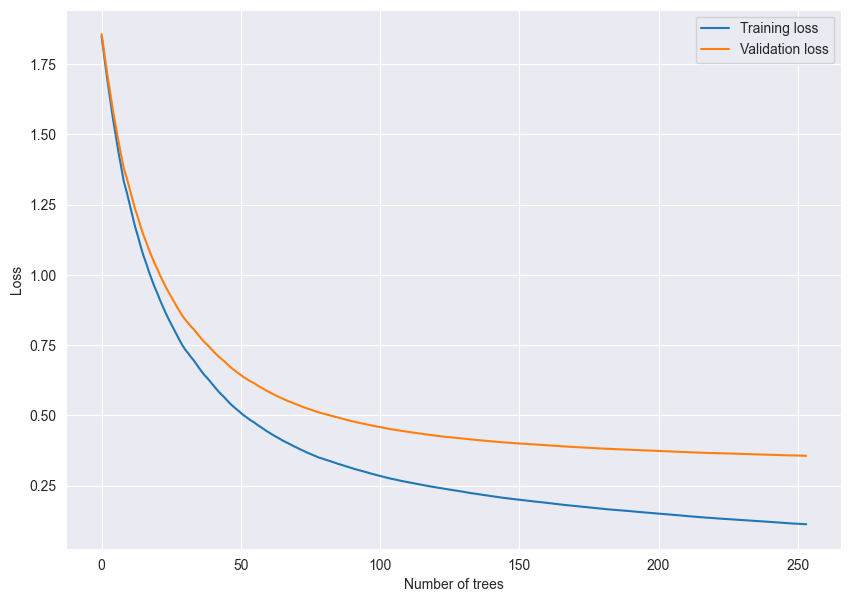

In [179]:
plot_error_xgb(xgb_test)

# feture correlation

In [227]:
df_corr = df_copy.drop(['Cover_Type'],axis=1).corr(method='spearman')

# 
mask = np.ones(df_corr.columns.size) - np.eye(df_corr.columns.size)
df_corr = mask * df_corr

df_corr

drops = []

for col in df_corr.columns.values:
    # if we've already determined to drop the current variable, continue
    if np.in1d([col],drops):
        continue

    
    corr = df_corr[abs(df_corr[col]) > 0.98].index
    # print(drops, corr)
    drops = np.union1d(drops, corr)

print("nDropping", drops.shape[0], "highly correlated features...n", drops)
# df.drop(drops, axis=1, inplace=True)

nDropping 4 highly correlated features...n ['Ele_Hillshade' 'Hillshade' 'Wilderness_Area1_soil'
 'Wilderness_Area3_soil']


# featuree creation using kmeans

In [209]:
from sklearn.cluster import KMeans
wild = []
for i in range(df.shape[0]):
    s = df.iloc[i]
    w = [s['Wilderness_Area1'], s['Wilderness_Area2'], s['Wilderness_Area3'], s['Wilderness_Area4']]
    for j in range(4):
        if w[j]:
            wild.append(j)
print(pd.Series(wild).value_counts())

soil_cols = []
for i in range(1, 41):
    soil_cols.append('Soil_Type'+str(i))

# soil_cols.append('Cover_Type')
soil = df[soil_cols]
knn = KMeans(n_clusters=4, random_state=0).fit(soil)
label = knn.labels_
print(pd.Series(label).value_counts())
# print(knn.cluster_centers_)

acc = 0
for i in range(df.shape[0]):
    if label[i] == wild[i]:
        acc += 1
print(acc / df.shape[0])

df_test = df.copy()
df_test['wild_Soil'] = wild 
df_test.corr()['wild_Soil'].sort_values(ascending=False)

2    6349
3    4675
0    3597
1     499
dtype: int64
0    10725
1     2142
3     1291
2      962
dtype: int64
0.1576058201058201


wild_Soil                             1.000000
Wilderness_Area4                      0.716697
Soil_Type10                           0.323429
Soil_Type3                            0.260855
Slope                                 0.245179
Soil_Type6                            0.227050
Cover_Type                            0.203883
Id                                    0.167781
Soil_Type1                            0.166110
Wilderness_Area3                      0.151655
Soil_Type17                           0.150794
Aspect                                0.126366
Soil_Type2                            0.120451
Soil_Type5                            0.112525
Soil_Type14                           0.104345
Vertical_Distance_To_Hydrology        0.098159
Soil_Type4                            0.093252
Hillshade_3pm                         0.065279
Soil_Type11                           0.056281
Soil_Type13                           0.031460
Soil_Type32                           0.028790
Soil_Type33  

In [ ]:
df_copy.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [216]:
from sklearn.neighbors import KNeighborsClassifier
data, target = soil, wild
knn = KNeighborsClassifier()
knn.fit(data, target)
knn.score(data, target)

0.6824074074074075

# Genetic selection

In [11]:
from genetic_selection import GeneticSelectionCV 

In [21]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from genetic_selection import GeneticSelectionCV 
# df_ = pd.DataFrame(data.data, columns=data.feature_names) 
# df_['target'] = data.target 
# X = df_.drop(['target'], axis=1) 
# y = df_['target'].astype(float)
X = df_copy.copy()
for col in df_copy.columns:
    X[col] = X[col].astype(float)
Y = y1.astype(float)
estimator = xgb_test
# estimator = xgb_test
model = GeneticSelectionCV( 
    estimator, cv=2, verbose=1, 
    scoring="accuracy", max_features=60, 
    n_population=400, crossover_proba=0.5, 
    mutation_proba=0.2, n_generations=20, 
    crossover_independent_proba=0.5, 
    mutation_independent_proba=0.1, 
    tournament_size=30, n_gen_no_change=10, 
    caching=True, n_jobs=-1) 
model = model.fit(x1, y1)
print('Features:', x1.columns[model.support_])

Selecting features with genetic algorithm.
gen	nevals	avg                               	std                               	min                            	max                               
0  	400   	[  0.709136  30.615      0.00434 ]	[  0.178484  17.558667   0.002563]	[ 0.154674  1.        0.      ]	[  0.836949  60.         0.011728]
1  	232   	[-99.175511  55.26     100.00543 ]	[ 995.070301    3.595469  994.986891]	[-10000.           42.            0.000441]	[     0.83836     61.       10000.     ]
2  	222   	[-199.181105   56.2675    200.005732]	[ 1400.116985     2.875055  1399.999181]	[-10000.           46.            0.001058]	[     0.841799     62.        10000.      ]
3  	233   	[-24.165725  56.4175    25.004422]   	[ 499.416375    2.945029  499.374388]   	[-10000.           44.            0.000176]	[     0.841799     61.        10000.      ]
4  	261   	[  0.838719  56.0025     0.003647]   	[ 0.004922  2.583117  0.001386]         	[  0.812875  45.         0.000353]         	[ 

In [17]:
selected_feature  = [
    'Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon',
    'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
    'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
    'Soil_Type1', 'Soil_Type2', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
    'Soil_Type10', 'Soil_Type11', 'Soil_Type16', 'Soil_Type17',
    'Soil_Type19', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
    'Soil_Type24', 'Soil_Type26', 'Soil_Type28', 'Soil_Type29',
    'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
    'Soil_Type35', 'Soil_Type38', 'Soil_Type39',
    'Distance_Roadways_FirPoints', 'Wilderness_Area1_soil',
    'Wilderness_Area2_soil', 'Wilderness_Area4_soil', 'Elevation-FirePoint',
    'Elevation_Road', 'Elevation-Road']

In [11]:
model.generation_scores_

array([0.83342152, 0.83756614, 0.83783069, 0.83783069, 0.84082892,
       0.84082892, 0.84082892, 0.84082892, 0.84082892, 0.84082892,
       0.84082892, 0.84082892, 0.84082892, 0.84082892, 0.84082892,
       0.84082892, 0.84082892, 0.84082892, 0.84082892, 0.84082892,
       0.84082892, 0.84082892])

In [18]:
df_test = feature_creation_alter(df.copy().drop(['Id'], axis=1))
data, target = df_test[selected_feature], df_test['Cover_Type']
x1, x2, y1, y2 = train_test_split(data, target)
y1 -= 1
y2 -= 1
xgb_test = train('xgb', x1, x2, y1, y2)
score(xgb_test, x1, x2, y1, y2)

c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train acc:  0.9952380952380953
test acc:  0.8592592592592593
cross validation score:  0.7968253968253969


# hyperopt feture selection 


In [42]:
import hyperopt
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp, space_eval
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

In [67]:
class HpOptBinarySelect:
    def __init__(self, X_train, X_test, y_train, y_test, space, model):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.parameter_space = space
        self.model = model
        print()
    def objective(self, params):
        # cols = [i for i, j in params.items() if j==1]
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict_proba(self.X_test)
        loss = log_loss(self.y_test.to_numpy(), y_pred, labels=[0,1,2,3,4,5,6])
        # loss = 1 - metrics.roc_auc_score(self.y_test, pred_proba[:, 1])
        return {'loss': loss, 'status': STATUS_OK}
    def optimize(self, max_evals=20):
        trials = Trials()
        best = fmin(fn=self.objective,
                    space=self.parameter_space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
        return space_eval(self.parameter_space, best)

In [65]:
space = {}
for col in df_copy.drop(['Cover_Type', 'Soil_Type7', 'Soil_Type15'], axis=1).columns:
    space[col] = hp.choice(col, [0, 1])

In [85]:
hpobj = HpOptBinarySelect(
    x1,
    x2, 
    y1, 
    y2, 
    space, 
    XGBClassifier())
best = hpobj.optimize(max_evals=200)
out = [i for i,j in best.items() if j==1]
print(f'Final number of features {len(out)}')


100%|██████████| 200/200 [25:38<00:00,  7.69s/trial, best loss: 0.35249997221437906]
Final number of features 33


In [70]:
forsubmissinDF['33'].astype(float)

,Aspect,Distance_Roadways_FirPoints,Elevation,Elevation_FirePoint,Elevation_Road,Hillshade_3pm,Hillshade_9am,Slope,Soil_Type11,Soil_Type12,...,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Vertical_Distance_To_Hydrology,Wilderness_Area1,Wilderness_Area2_soil,Wilderness_Area3,Wilderness_Area3_soil,Wilderness_Area4_soil
4162,195,5258,3052,6650,4712,165,216,16,0,0,...,0,0,0,0,72,1,0,0,0,0
7078,151,2000,2630,3415,3845,130,237,13,0,0,...,0,0,0,0,-2,0,0,1,1,0
7828,24,5292,3388,5491,6577,130,211,15,0,0,...,0,0,0,0,149,0,0,1,1,0
9368,357,7645,3377,6983,7416,151,189,18,0,0,...,0,0,0,0,192,0,1,1,1,0
642,7,4612,2769,5549,4601,150,209,9,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,114,1989,2189,2714,3653,55,254,27,0,0,...,0,0,0,0,0,0,0,0,0,1
13418,124,1155,2317,2877,2912,140,229,5,0,0,...,0,0,0,0,0,0,0,0,0,1
5390,153,2078,2962,3432,4570,128,237,15,0,0,...,0,0,0,0,23,0,0,1,2,0
860,254,6471,2898,4450,7817,179,204,7,0,0,...,0,0,0,0,6,1,0,0,0,0


In [73]:
x2[out]

,Aspect,Distance_Roadways_FirPoints,Elevation,Elevation_FirePoint,Elevation_Road,Hillshade_3pm,Hillshade_9am,Slope,Soil_Type11,Soil_Type12,...,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Vertical_Distance_To_Hydrology,Wilderness_Area1,Wilderness_Area2_soil,Wilderness_Area3,Wilderness_Area3_soil,Wilderness_Area4_soil
6077,147,1869,2432,3817,2916,120,240,16,0,0,...,0,1,0,0,2,0,0,0,0,1
7894,114,4623,2653,4998,4931,107,244,14,0,0,...,0,0,0,0,38,0,0,1,1,0
6820,315,4666,3542,4990,6760,206,124,31,0,0,...,0,0,0,0,130,1,1,0,0,0
1593,286,5746,3191,3972,8156,212,162,20,0,0,...,0,0,0,0,12,1,0,0,0,0
11986,64,724,2160,2644,2400,15,225,37,0,0,...,0,0,0,0,96,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651,333,2530,2319,3729,3439,169,197,10,0,0,...,0,0,0,0,0,0,0,0,0,1
10918,221,3993,2672,3878,5459,203,169,30,0,0,...,0,0,0,0,89,0,0,1,1,0
11398,357,4337,2502,6168,3173,156,206,9,0,0,...,0,0,0,0,24,1,0,0,0,0
6756,81,1890,2996,4383,3499,25,243,33,0,0,...,0,0,0,0,0,1,0,0,0,0


In [86]:
train_X, test_X, train_Y, test_Y = x1[out], x2[out], y1, y2
xgb_test = XGBClassifier()
xgb_test.fit(train_X, train_Y)
pred_proba = xgb_test.predict_proba(test_X)
# loss = log_loss(y2, pred_proba, labels=[0,1,2,3,4,5,6])

In [87]:
pred = xgb_test.predict_proba(test_X)
pred 
loss = log_loss(test_Y.to_numpy(), pred, labels=[0,1,2,3,4,5,6])
loss

0.4282537284984106

In [93]:
from joblib import load 
xgb_load = load('model/xgb.joblib')

In [95]:
score(xgb_load, x1_, x2_, y1_, y2_)

train acc:  0.9973544973544973
test acc:  0.8764550264550265
cross validation score:  0.8145502645502646


In [96]:
df_copy

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Distance_Roadways_FirPoints,Ele_Hillshade,Wilderness_Area1_soil,Wilderness_Area2_soil,Wilderness_Area3_soil,Wilderness_Area4_soil,Elevation_FirePoint,Elevation-FirePoint,Elevation_Road,Elevation-Road
0,2596,51,3,258,0,510,221,232,148,6279,...,6789,1995,2,0,0,0,8875,-3683,3106,2086
1,2590,56,2,212,-6,390,220,235,151,6225,...,6615,1984,2,0,0,0,8815,-3635,2980,2200
2,2804,139,9,268,65,3180,234,238,135,6121,...,9301,2197,1,0,0,0,8925,-3317,5984,-376
3,2785,155,18,242,118,3090,238,238,122,6211,...,9301,2187,1,0,0,0,8996,-3426,5875,-305
4,2595,45,2,153,-1,391,220,234,150,6172,...,6563,1991,2,0,0,0,8767,-3577,2986,2204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2607,243,23,258,7,660,170,251,214,1282,...,1942,1972,0,0,1,0,3889,1325,3267,1947
15116,2603,121,19,633,195,618,249,221,91,1325,...,1943,2042,0,0,1,0,3928,1278,3221,1985
15117,2492,134,25,365,117,335,250,220,83,1187,...,1522,1939,0,0,1,0,3679,1305,2827,2157
15118,2487,167,28,218,101,242,229,237,119,932,...,1174,1902,0,0,1,0,3419,1555,2729,2245


In [97]:
# submission 
test = pd.read_csv('data/test.csv')
test = feature_creation(test)

# submission

### stacking classifier

In [102]:
clf_load = load('model/clf.joblib')
data = test.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis=1)
pred = clf_load.predict(data)

In [106]:
submission = pd.read_csv('data/sampleSubmission.csv')
id = submission['Id']

In [115]:
submissionDF = pd.DataFrame({
    'Id':id
})
# submissionDF['Id'] = id
submissionDF['Cover_Type'] = pred + 1
submissionDF.to_csv('data/Stacking.csv', index=False)

### baseline

In [123]:
# Test for baseline 
data, target = df.drop(['Id', 'Cover_Type', 'Soil_Type7', 'Soil_Type15'], axis=1), df['Cover_Type']
x1, x2, y1, y2 = train_test_split(data, target)
y1 -= 1
y2 -= 1
xgb_test = train('xgb', x1, x2, y1, y2)
score(xgb_test, x1, x2, y1, y2)

c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train acc:  0.9899470899470899
test acc:  0.8542328042328042
cross validation score:  0.7767195767195767


In [126]:
submission = pd.read_csv('data/sampleSubmission.csv')
id = submission['Id']
test_data = pd.read_csv('data/test.csv')
test_data.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
pred = xgb_test.predict(test_data)

submissionDF = pd.DataFrame({
    'Id':id
})
# submissionDF['Id'] = id
submissionDF['Cover_Type'] = pred + 1
submissionDF.to_csv('data/baseline.csv', index=False)

### feature creation (altered)

In [127]:
data, target = feature_creation_alter(df.drop(['Id', 'Cover_Type', 'Soil_Type7', 'Soil_Type15'], axis=1)), df['Cover_Type']
x1, x2, y1, y2 = train_test_split(data, target)
y1 -= 1
y2 -= 1
xgb_test = train('xgb', x1, x2, y1, y2)
score(xgb_test, x1, x2, y1, y2)

c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train acc:  0.9978835978835979
test acc:  0.8740740740740741
cross validation score:  0.8050264550264551


In [128]:
submission = pd.read_csv('data/sampleSubmission.csv')
id = submission['Id']
test_data = pd.read_csv('data/test.csv')
test_data.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
test_data = feature_creation_alter(test_data)
pred = xgb_test.predict(test_data)
submissionDF = pd.DataFrame({
    'Id':id
})
# submissionDF['Id'] = id
submissionDF['Cover_Type'] = pred + 1
submissionDF.to_csv('data/feature_creation.csv', index=False)

### feature creation without reducing any features

In [129]:
data, target = feature_creation(df.drop(['Id', 'Cover_Type', 'Soil_Type7', 'Soil_Type15'], axis=1)), df['Cover_Type']
x1, x2, y1, y2 = train_test_split(data, target)
y1 -= 1
y2 -= 1
xgb_test = train('xgb', x1, x2, y1, y2)
score(xgb_test, x1, x2, y1, y2)

c:\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train acc:  0.9981481481481481
test acc:  0.8690476190476191
cross validation score:  0.8023809523809525


In [131]:
submission = pd.read_csv('data/sampleSubmission.csv')
id = submission['Id']
test_data = pd.read_csv('data/test.csv')
test_data.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
test_data = feature_creation(test_data)
pred = xgb_test.predict(test_data)
submissionDF = pd.DataFrame({
    'Id':id
})
# submissionDF['Id'] = id
submissionDF['Cover_Type'] = pred + 1
submissionDF.to_csv('data/feature_creation_no_reduce.csv', index=False)